## Environment Setup

**Upload following files to current directory**

1.   *requirements.txt*
2.   *dataloader.py*
3.   *capsule_network.py*
4.   *ccm_pruner.py*
5.   *utils.py*
6.   *model_train_test.py*

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(name=fn))

Saving capsule_network.py to capsule_network.py
Saving ccm_pruner.py to ccm_pruner.py
Saving dataloader.py to dataloader.py
Saving model_train_test.py to model_train_test.py
Saving requirements.txt to requirements.txt
Saving utils.py to utils.py
User uploaded file "capsule_network.py"
User uploaded file "ccm_pruner.py"
User uploaded file "dataloader.py"
User uploaded file "model_train_test.py"
User uploaded file "requirements.txt"
User uploaded file "utils.py"


In [ ]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ROOT="/content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/"

Mounted at /content/drive


Importing required libraries

In [ ]:
import os, gc
import random
import shutil
import time, datetime
from thop import vision, profile, clever_format
from flopth import flopth
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F

import capsule_network as caps
import ccm_pruner as ccmp
import model_train_test as mtt
import utils
from dataloader import image_dataloader

CapsuleNet is using device: cuda


Device (CPU/GPU) available to use.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('This notebook using device:', device)

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.random.manual_seed(random_seed)

This notebook using device: cuda


Setting up logger and directories

In [ ]:
try:
    ROOT
except NameError:
    ROOT="./results/"
    if not os.path.exists(ROOT):
        os.makedirs(ROOT)

print('ROOT Directory:', ROOT)

TRAIN_DIR = ROOT+"train/"
LOG_DIR = ROOT+"logs/"

logger = utils.get_logger(LOG_DIR)

ROOT Directory: /content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/


In [ ]:
def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()

## Single Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/20Caps8Dim/"
batch_size=32
n_epochs=30
n_class=10

n_caps_layers=1
prim_caps_channels=20
prim_caps_dim=8

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter1_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter1_capsnet_cifar10_model.name = 'multilayer_inter1_capsnet_cifar10_model'
multilayer_inter1_capsnet_cifar10_model = multilayer_inter1_capsnet_cifar10_model.to(device)
multilayer_inter1_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
  )
  (class_caps): CapsLayer()
)

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter1_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/04 02:16:09 PM | multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.6131, Top 1 Acc=12.50, Top 5 Acc=59.38
INFO:capsnet:multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.6131, Top 1 Acc=12.50, Top 5 Acc=59.38
02/04 02:16:15 PM | multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5147, Top 1 Acc=22.16, Top 5 Acc=69.32
INFO:capsnet:multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5147, Top 1 Acc=22.16, Top 5 Acc=69.32
02/04 02:16:21 PM | multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4873, Top 1 Acc=26.88, Top 5 Acc=74.18
INFO:capsnet:multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4873, Top 1 Acc=26.88, Top 5 Acc=74.18
02/04 02:16:26 PM | multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.4683, Top 1 Acc=29.64, Top 5 Acc=

CPU times: user 2h 20min 24s, sys: 5min 14s, total: 2h 25min 39s
Wall time: 2h 25min 17s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter1_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter1_capsnet_cifar10_model.pt')

best_multilayer_inter1_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter1_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter1_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter1_capsnet_cifar10_model.name = 'best_multilayer_inter1_capsnet_cifar10_model'
best_multilayer_inter1_capsnet_cifar10_model = best_multilayer_inter1_capsnet_cifar10_model.to(device)
best_multilayer_inter1_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
  )
  (class_caps): CapsLayer()
)

In [ ]:
capsnet_inter1_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter1_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/17 01:11:24 AM | best_multilayer_inter1_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=93.750, Top 5 Acc=100.000
INFO:capsnet:best_multilayer_inter1_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=93.750, Top 5 Acc=100.000
02/17 01:11:24 AM | best_multilayer_inter1_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=78.125, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter1_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=78.125, Top 5 Acc=96.875
02/17 01:11:24 AM | best_multilayer_inter1_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=79.167, Top 5 Acc=97.917
INFO:capsnet:best_multilayer_inter1_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=79.167, Top 5 Acc=97.917
02/17 01:11:24 AM | best_multilayer_inter1_capsnet_cifar10_model - Iterations=4/313, Batch Size=32, Top 1 Acc=80.469, Top 5 Acc=98.438
INFO:capsnet:best_multilayer_inter1_capsnet_cifar10_model - Iterations=4/3

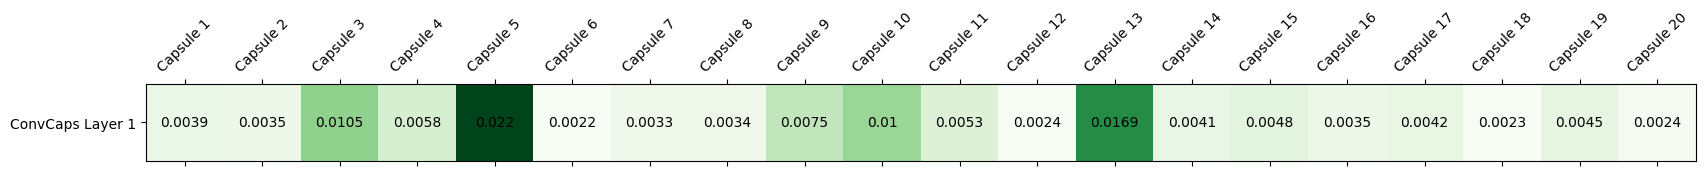

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter1_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter1_capsnet_cifar10_model_Epoch30_of_30.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

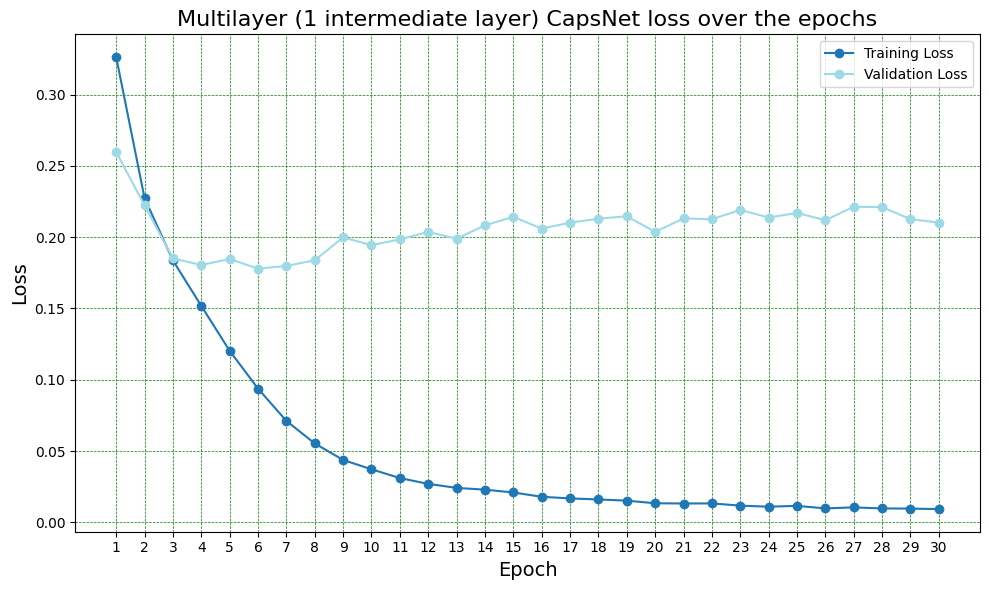

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (1 intermediate layer) CapsNet loss over the epochs')

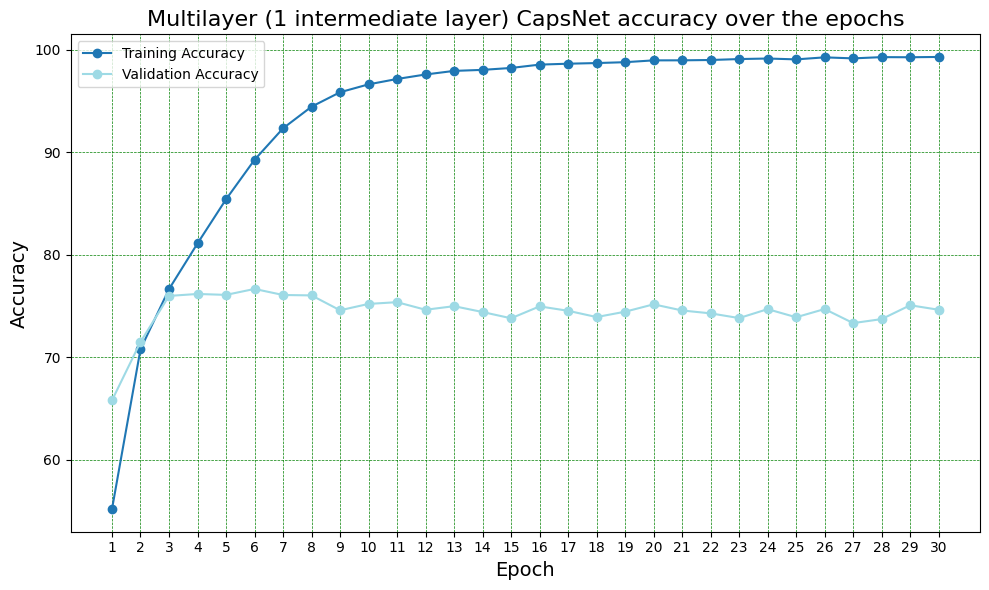

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (1 intermediate layer) CapsNet accuracy over the epochs')

## 2 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/20Caps8Dim/"
batch_size=32
n_epochs=15
n_class=10

n_caps_layers=2
prim_caps_channels=20
prim_caps_dim=8

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size':[3, 3, 3, 3],
                     'stride':[1, 2, 1, 2],
                     'padding':[1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter2_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter2_capsnet_cifar10_model.name = 'multilayer_inter2_capsnet_cifar10_model'
multilayer_inter2_capsnet_cifar10_model = multilayer_inter2_capsnet_cifar10_model.to(device)
multilayer_inter2_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
  )
  (class_caps): CapsLayer()
)

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter2_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/04 06:12:45 PM | multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7666, Top 1 Acc=6.25, Top 5 Acc=43.75
INFO:capsnet:multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.7666, Top 1 Acc=6.25, Top 5 Acc=43.75
02/04 06:12:54 PM | multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.4998, Top 1 Acc=23.67, Top 5 Acc=73.77
INFO:capsnet:multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.4998, Top 1 Acc=23.67, Top 5 Acc=73.77
02/04 06:13:04 PM | multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4694, Top 1 Acc=29.90, Top 5 Acc=77.84
INFO:capsnet:multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4694, Top 1 Acc=29.90, Top 5 Acc=77.84
02/04 06:13:13 PM | multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.4542, Top 1 Acc=32.35, Top 5 Acc=80

CPU times: user 1h 56min 21s, sys: 3min 25s, total: 1h 59min 46s
Wall time: 1h 59min 24s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter2_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter2_capsnet_cifar10_model.pt')

best_multilayer_inter2_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter2_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter2_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter2_capsnet_cifar10_model.name = 'best_multilayer_inter2_capsnet_cifar10_model'
best_multilayer_inter2_capsnet_cifar10_model = best_multilayer_inter2_capsnet_cifar10_model.to(device)
best_multilayer_inter2_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
  )
  (class_caps): CapsLayer()
)

In [ ]:
capsnet_inter2_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter2_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/17 01:07:34 AM | best_multilayer_inter2_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=87.500, Top 5 Acc=100.000
INFO:capsnet:best_multilayer_inter2_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=87.500, Top 5 Acc=100.000
02/17 01:07:34 AM | best_multilayer_inter2_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=76.562, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter2_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=76.562, Top 5 Acc=96.875
02/17 01:07:34 AM | best_multilayer_inter2_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=79.167, Top 5 Acc=97.917
INFO:capsnet:best_multilayer_inter2_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=79.167, Top 5 Acc=97.917
02/17 01:07:34 AM | best_multilayer_inter2_capsnet_cifar10_model - Iterations=4/313, Batch Size=32, Top 1 Acc=80.469, Top 5 Acc=97.656
INFO:capsnet:best_multilayer_inter2_capsnet_cifar10_model - Iterations=4/3

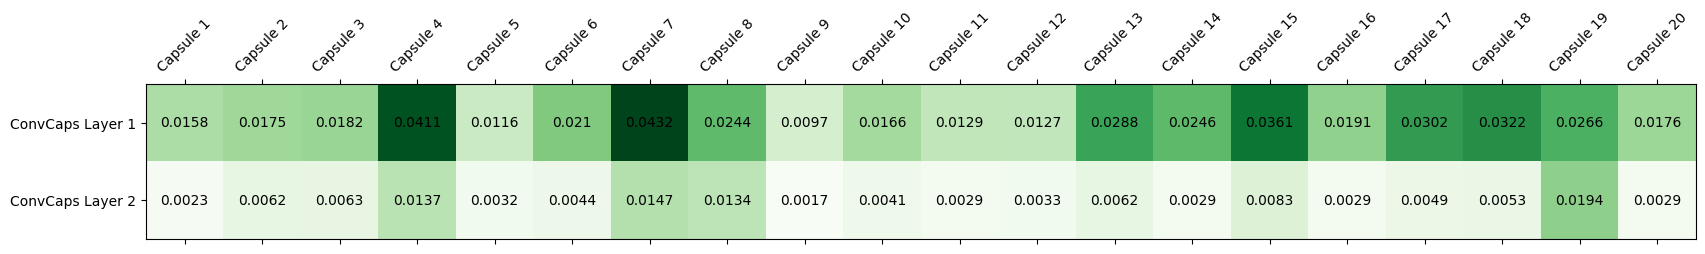

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter2_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter2_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

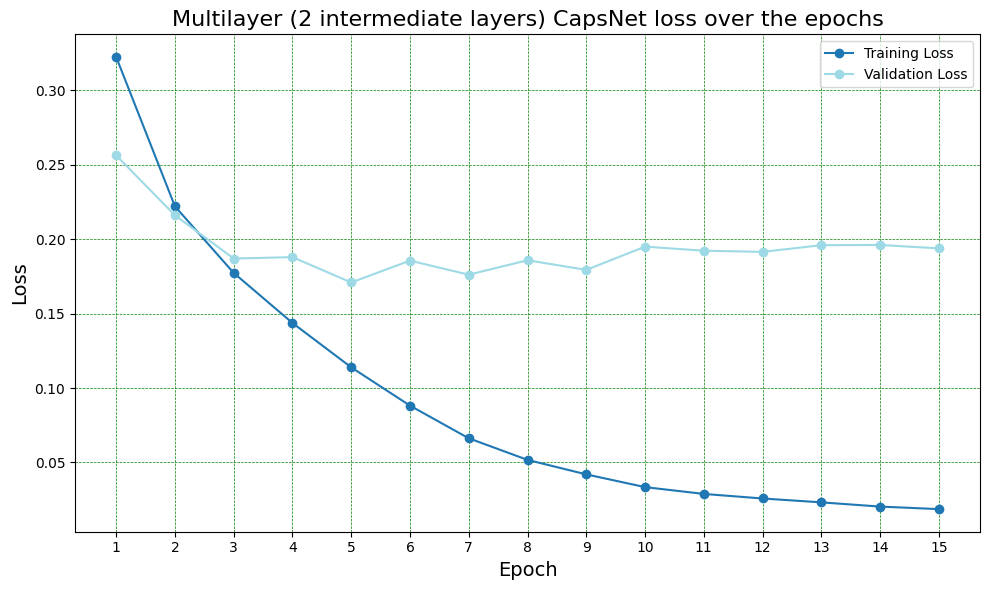

In [ ]:
utils.plot_line_chart(epoch_loss[:, :15], ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (2 intermediate layers) CapsNet loss over the epochs')

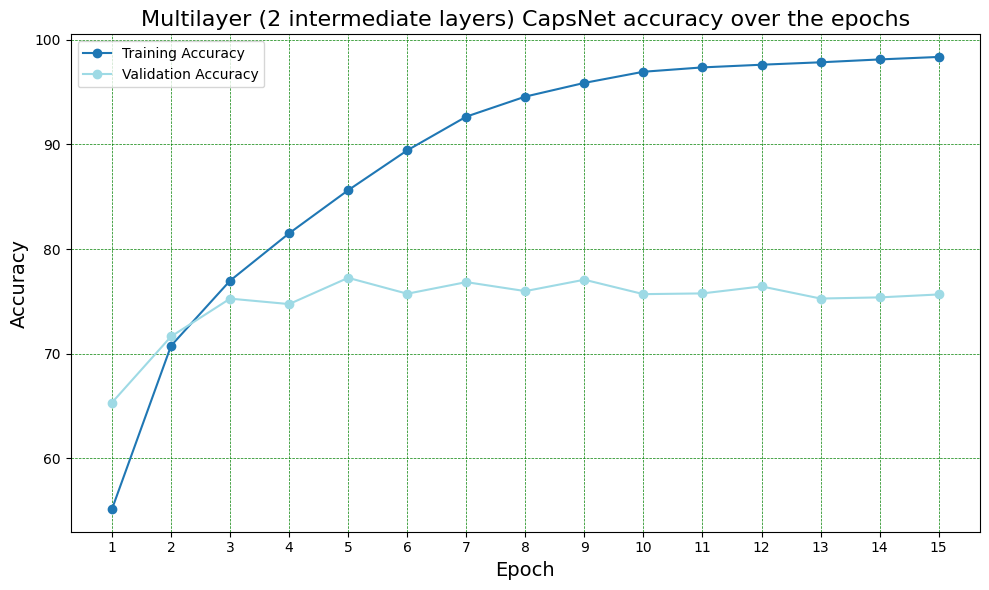

In [ ]:
utils.plot_line_chart(epoch_accuracy[:, :15], ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (2 intermediate layers) CapsNet accuracy over the epochs')

## 3 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/20Caps8Dim/"
batch_size=32
n_epochs=15
n_class=10

n_caps_layers=3
prim_caps_channels=20
prim_caps_dim=8

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size':[3, 3, 3, 3],
                     'stride':[1, 2, 1, 2],
                     'padding':[1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter3_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter3_capsnet_cifar10_model.name = 'multilayer_inter3_capsnet_cifar10_model'
multilayer_inter3_capsnet_cifar10_model = multilayer_inter3_capsnet_cifar10_model.to(device)
multilayer_inter3_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
  )
  (class_caps): 

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter3_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/11 01:26:10 PM | multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.8046, Top 1 Acc=12.50, Top 5 Acc=53.12
INFO:capsnet:multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.8046, Top 1 Acc=12.50, Top 5 Acc=53.12
02/11 01:26:16 PM | multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5164, Top 1 Acc=22.35, Top 5 Acc=69.03
INFO:capsnet:multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5164, Top 1 Acc=22.35, Top 5 Acc=69.03
02/11 01:26:22 PM | multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4819, Top 1 Acc=26.73, Top 5 Acc=76.97
INFO:capsnet:multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4819, Top 1 Acc=26.73, Top 5 Acc=76.97
02/11 01:26:28 PM | multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.4602, Top 1 Acc=30.80, Top 5 Acc=

CPU times: user 1h 12min 54s, sys: 4min 22s, total: 1h 17min 17s
Wall time: 1h 17min 18s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter3_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter3_capsnet_cifar10_model.pt')

best_multilayer_inter3_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter3_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter3_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter3_capsnet_cifar10_model.name = 'best_multilayer_inter3_capsnet_cifar10_model'
best_multilayer_inter3_capsnet_cifar10_model = best_multilayer_inter3_capsnet_cifar10_model.to(device)
best_multilayer_inter3_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
  )
  (class_caps): 

In [ ]:
capsnet_inter3_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter3_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/17 01:04:55 AM | best_multilayer_inter3_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=93.750, Top 5 Acc=100.000
INFO:capsnet:best_multilayer_inter3_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=93.750, Top 5 Acc=100.000
02/17 01:04:55 AM | best_multilayer_inter3_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=79.688, Top 5 Acc=98.438
INFO:capsnet:best_multilayer_inter3_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=79.688, Top 5 Acc=98.438
02/17 01:04:55 AM | best_multilayer_inter3_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=78.125, Top 5 Acc=97.917
INFO:capsnet:best_multilayer_inter3_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=78.125, Top 5 Acc=97.917
02/17 01:04:55 AM | best_multilayer_inter3_capsnet_cifar10_model - Iterations=4/313, Batch Size=32, Top 1 Acc=78.125, Top 5 Acc=97.656
INFO:capsnet:best_multilayer_inter3_capsnet_cifar10_model - Iterations=4/3

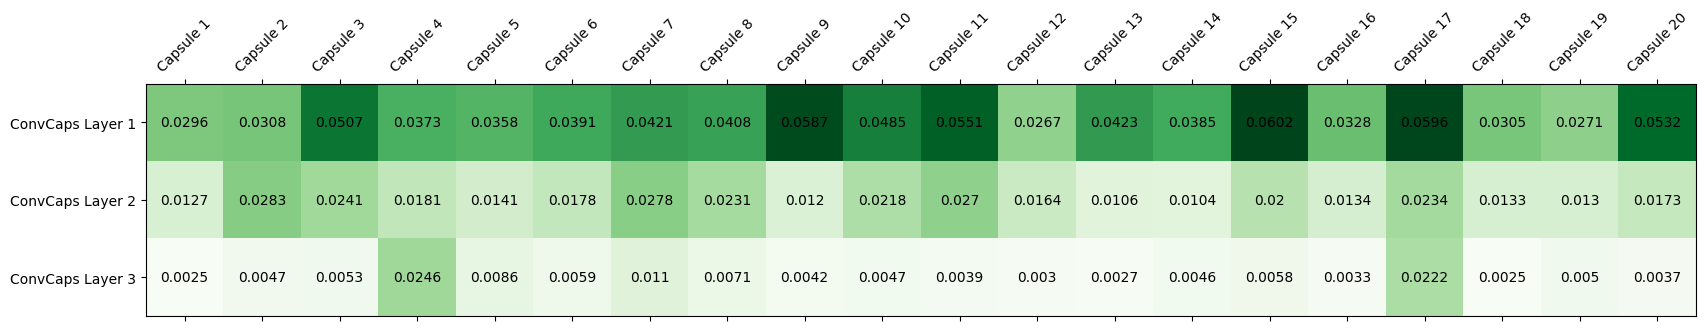

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter3_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter3_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

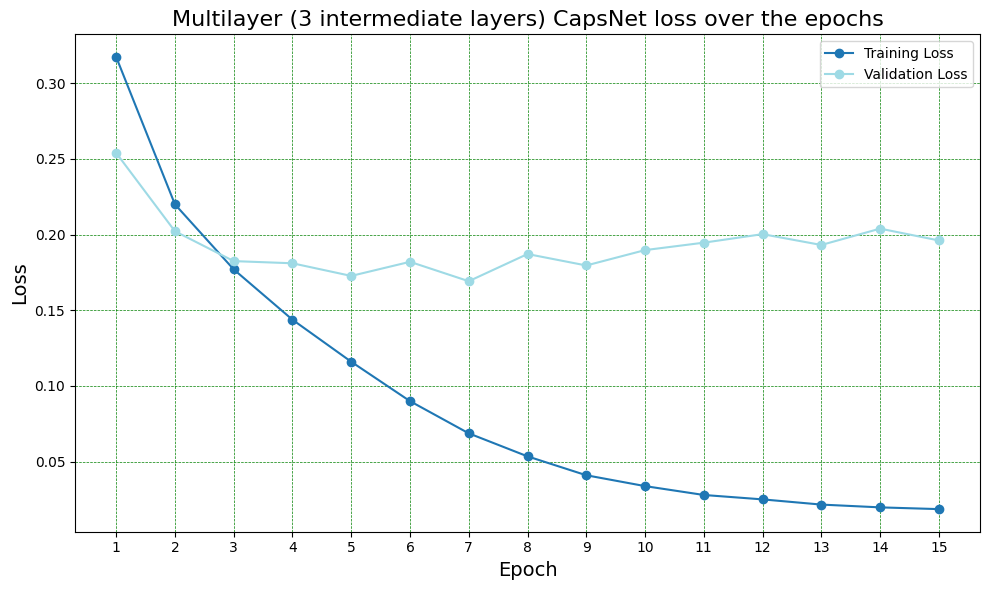

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (3 intermediate layers) CapsNet loss over the epochs')

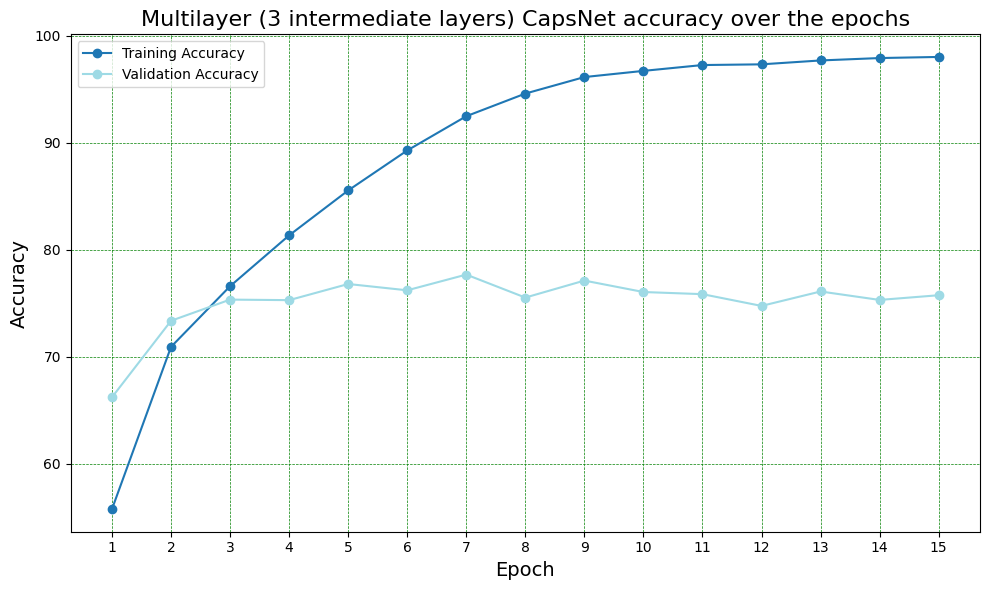

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (3 intermediate layers) CapsNet accuracy over the epochs')

## 4 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/20Caps8Dim/"
batch_size=32
n_epochs=15
n_class=10

n_caps_layers=4
prim_caps_channels=20
prim_caps_dim=8

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size':[3, 3, 3, 3],
                     'stride':[1, 2, 1, 2],
                     'padding':[1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter4_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter4_capsnet_cifar10_model.name = 'multilayer_inter4_capsnet_cifar10_model'
multilayer_inter4_capsnet_cifar10_model = multilayer_inter4_capsnet_cifar10_model.to(device)
multilayer_inter4_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter4_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/11 02:43:28 PM | multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.8099, Top 1 Acc=0.00, Top 5 Acc=31.25
INFO:capsnet:multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.8099, Top 1 Acc=0.00, Top 5 Acc=31.25
02/11 02:43:36 PM | multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5213, Top 1 Acc=20.93, Top 5 Acc=70.17
INFO:capsnet:multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5213, Top 1 Acc=20.93, Top 5 Acc=70.17
02/11 02:43:43 PM | multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4853, Top 1 Acc=26.59, Top 5 Acc=75.34
INFO:capsnet:multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.4853, Top 1 Acc=26.59, Top 5 Acc=75.34
02/11 02:43:51 PM | multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.4625, Top 1 Acc=30.90, Top 5 Acc=78

CPU times: user 1h 30min 31s, sys: 5min 19s, total: 1h 35min 51s
Wall time: 1h 35min 38s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter4_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter4_capsnet_cifar10_model.pt')

best_multilayer_inter4_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter4_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter4_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter4_capsnet_cifar10_model.name = 'best_multilayer_inter4_capsnet_cifar10_model'
best_multilayer_inter4_capsnet_cifar10_model = best_multilayer_inter4_capsnet_cifar10_model.to(device)
best_multilayer_inter4_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
capsnet_inter4_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter4_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/17 01:02:26 AM | best_multilayer_inter4_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=81.250, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter4_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=81.250, Top 5 Acc=96.875
02/17 01:02:26 AM | best_multilayer_inter4_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=75.000, Top 5 Acc=92.188
INFO:capsnet:best_multilayer_inter4_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=75.000, Top 5 Acc=92.188
02/17 01:02:26 AM | best_multilayer_inter4_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=78.125, Top 5 Acc=94.792
INFO:capsnet:best_multilayer_inter4_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=78.125, Top 5 Acc=94.792
02/17 01:02:27 AM | best_multilayer_inter4_capsnet_cifar10_model - Iterations=4/313, Batch Size=32, Top 1 Acc=78.906, Top 5 Acc=96.094
INFO:capsnet:best_multilayer_inter4_capsnet_cifar10_model - Iterations=4/313

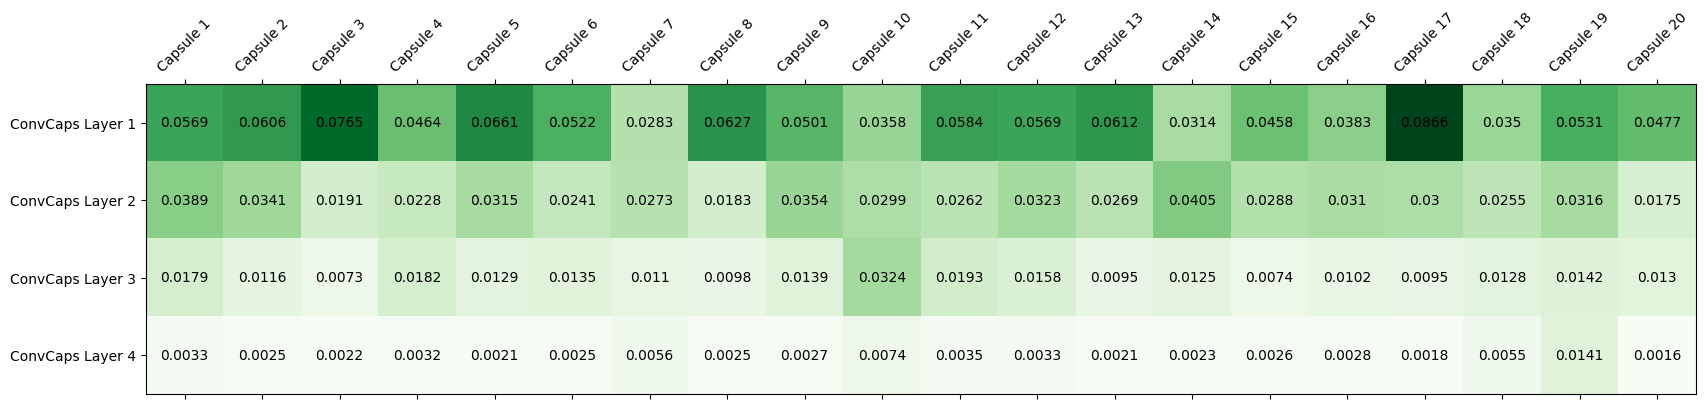

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter4_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter4_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

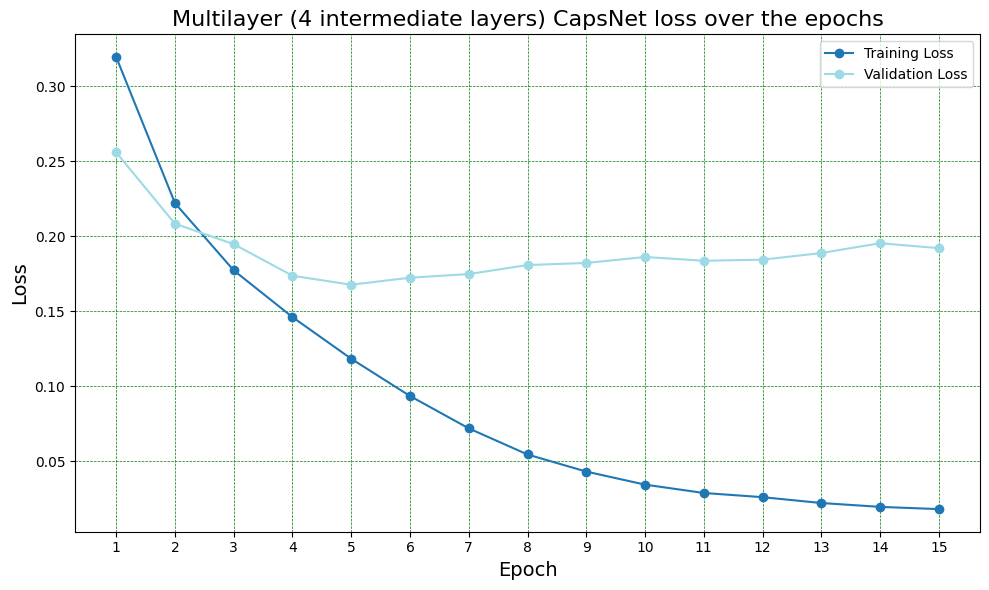

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (4 intermediate layers) CapsNet loss over the epochs')

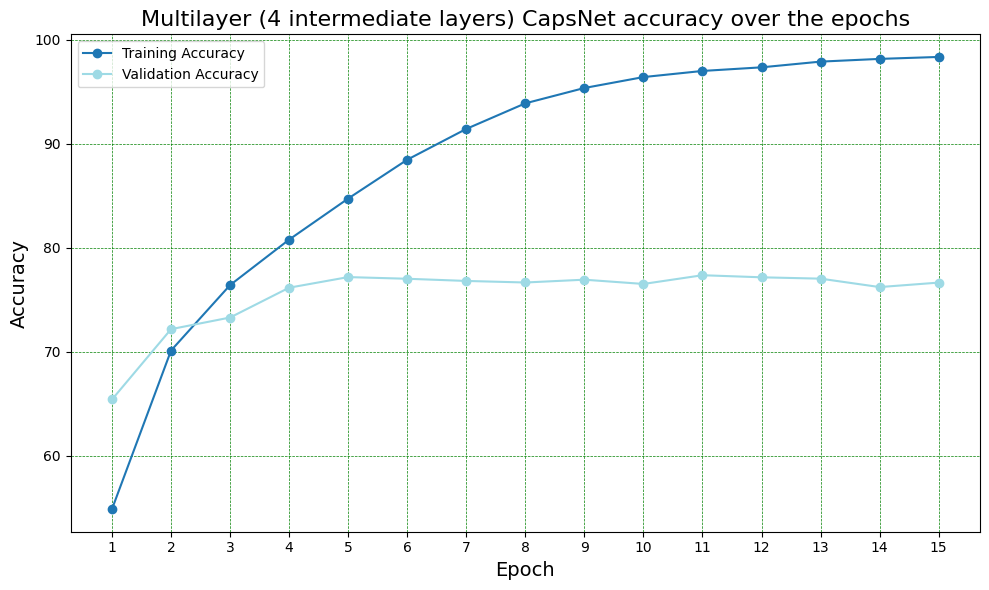

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (4 intermediate layers) CapsNet accuracy over the epochs')

## 5 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/20Caps8Dim/"
batch_size=32
n_epochs=15
n_class=10

n_caps_layers=5
prim_caps_channels=20
prim_caps_dim=8

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size':[3, 3, 3, 3],
                     'stride':[1, 2, 1, 2],
                     'padding':[1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter5_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter5_capsnet_cifar10_model.name = 'multilayer_inter5_capsnet_cifar10_model'
multilayer_inter5_capsnet_cifar10_model = multilayer_inter5_capsnet_cifar10_model.to(device)
multilayer_inter5_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter5_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/08 12:34:32 AM | multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.8100, Top 1 Acc=18.75, Top 5 Acc=56.25
INFO:capsnet:multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.8100, Top 1 Acc=18.75, Top 5 Acc=56.25
02/08 12:34:42 AM | multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5501, Top 1 Acc=16.38, Top 5 Acc=61.55
INFO:capsnet:multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.5501, Top 1 Acc=16.38, Top 5 Acc=61.55
02/08 12:34:53 AM | multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5018, Top 1 Acc=22.93, Top 5 Acc=71.30
INFO:capsnet:multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5018, Top 1 Acc=22.93, Top 5 Acc=71.30
02/08 12:35:04 AM | multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.4728, Top 1 Acc=27.42, Top 5 Acc=

CPU times: user 2h 4min 26s, sys: 6min 52s, total: 2h 11min 18s
Wall time: 2h 12min 24s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter5_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter5_capsnet_cifar10_model.pt')

best_multilayer_inter5_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter5_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter5_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter5_capsnet_cifar10_model.name = 'best_multilayer_inter5_capsnet_cifar10_model'
best_multilayer_inter5_capsnet_cifar10_model = best_multilayer_inter5_capsnet_cifar10_model.to(device)
best_multilayer_inter5_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
capsnet_inter5_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter5_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/17 12:58:33 AM | best_multilayer_inter5_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=96.875, Top 5 Acc=100.000
INFO:capsnet:best_multilayer_inter5_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=96.875, Top 5 Acc=100.000
02/17 12:58:33 AM | best_multilayer_inter5_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=84.375, Top 5 Acc=98.438
INFO:capsnet:best_multilayer_inter5_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=84.375, Top 5 Acc=98.438
02/17 12:58:33 AM | best_multilayer_inter5_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=83.333, Top 5 Acc=98.958
INFO:capsnet:best_multilayer_inter5_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=83.333, Top 5 Acc=98.958
02/17 12:58:33 AM | best_multilayer_inter5_capsnet_cifar10_model - Iterations=4/313, Batch Size=32, Top 1 Acc=81.250, Top 5 Acc=97.656
INFO:capsnet:best_multilayer_inter5_capsnet_cifar10_model - Iterations=4/3

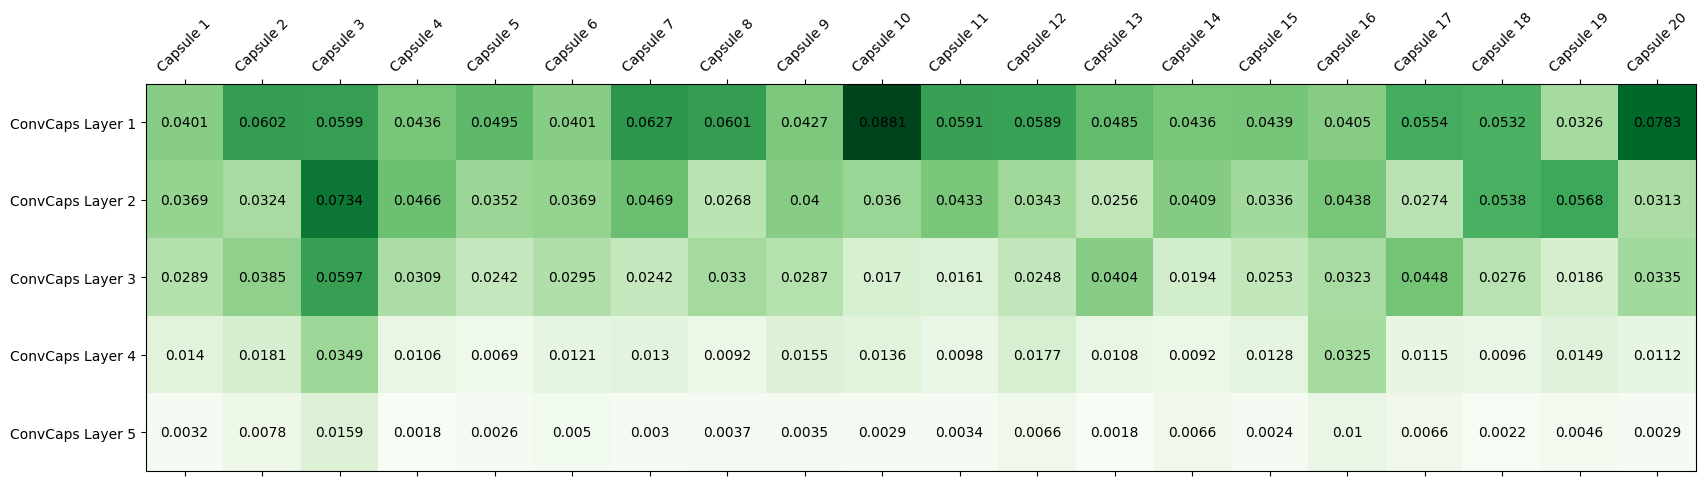

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter5_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter5_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

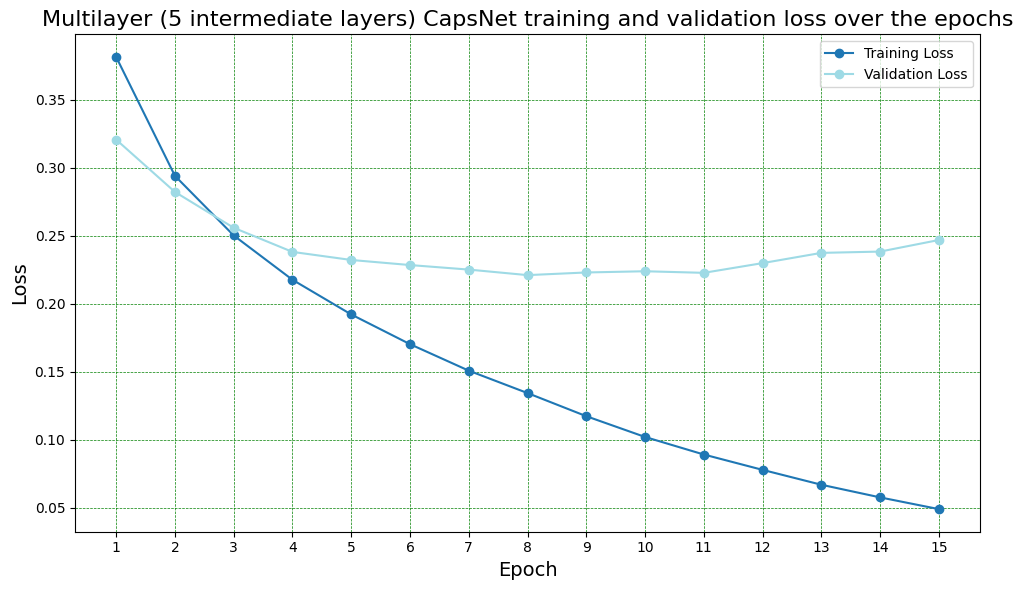

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (5 intermediate layers) CapsNet loss over the epochs')

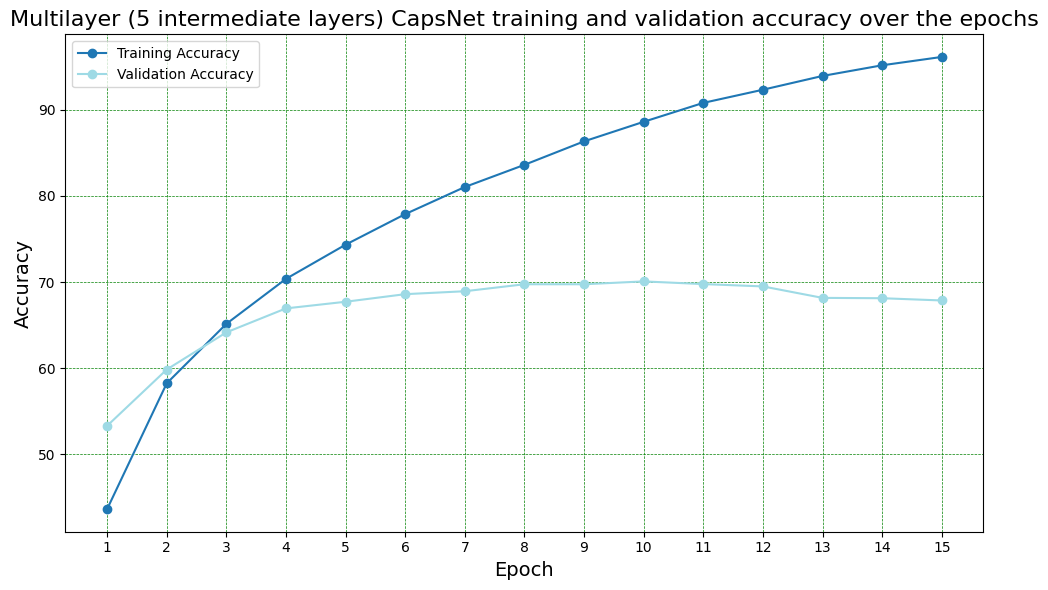

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (5 intermediate layers) CapsNet accuracy over the epochs')

## 6 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/20Caps8Dim/"
batch_size=32
n_epochs=15
n_class=10

n_caps_layers=6
prim_caps_channels=20
prim_caps_dim=8

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size':[3, 3, 3, 3],
                     'stride':[1, 2, 1, 2],
                     'padding':[1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter6_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter6_capsnet_cifar10_model.name = 'multilayer_inter6_capsnet_cifar10_model'
multilayer_inter6_capsnet_cifar10_model = multilayer_inter6_capsnet_cifar10_model.to(device)
multilayer_inter6_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter6_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/11 04:19:10 PM | multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.8100, Top 1 Acc=9.38, Top 5 Acc=46.88
INFO:capsnet:multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.8100, Top 1 Acc=9.38, Top 5 Acc=46.88
02/11 04:19:20 PM | multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6476, Top 1 Acc=10.23, Top 5 Acc=52.56
INFO:capsnet:multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.6476, Top 1 Acc=10.23, Top 5 Acc=52.56
02/11 04:19:31 PM | multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5667, Top 1 Acc=15.38, Top 5 Acc=63.99
INFO:capsnet:multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.5667, Top 1 Acc=15.38, Top 5 Acc=63.99
02/11 04:19:42 PM | multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.5300, Top 1 Acc=19.88, Top 5 Acc=69

CPU times: user 2h 7min 3s, sys: 7min 17s, total: 2h 14min 21s
Wall time: 2h 14min 2s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter6_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter6_capsnet_cifar10_model.pt')

best_multilayer_inter6_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter6_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter6_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter6_capsnet_cifar10_model.name = 'best_multilayer_inter6_capsnet_cifar10_model'
best_multilayer_inter6_capsnet_cifar10_model = best_multilayer_inter6_capsnet_cifar10_model.to(device)
best_multilayer_inter6_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
capsnet_inter6_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter6_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/17 12:52:42 AM | best_multilayer_inter6_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=90.625, Top 5 Acc=100.000
INFO:capsnet:best_multilayer_inter6_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=90.625, Top 5 Acc=100.000
02/17 12:52:42 AM | best_multilayer_inter6_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=78.125, Top 5 Acc=95.312
INFO:capsnet:best_multilayer_inter6_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=78.125, Top 5 Acc=95.312
02/17 12:52:43 AM | best_multilayer_inter6_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=77.083, Top 5 Acc=95.833
INFO:capsnet:best_multilayer_inter6_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=77.083, Top 5 Acc=95.833
02/17 12:52:43 AM | best_multilayer_inter6_capsnet_cifar10_model - Iterations=4/313, Batch Size=32, Top 1 Acc=77.344, Top 5 Acc=96.094
INFO:capsnet:best_multilayer_inter6_capsnet_cifar10_model - Iterations=4/3

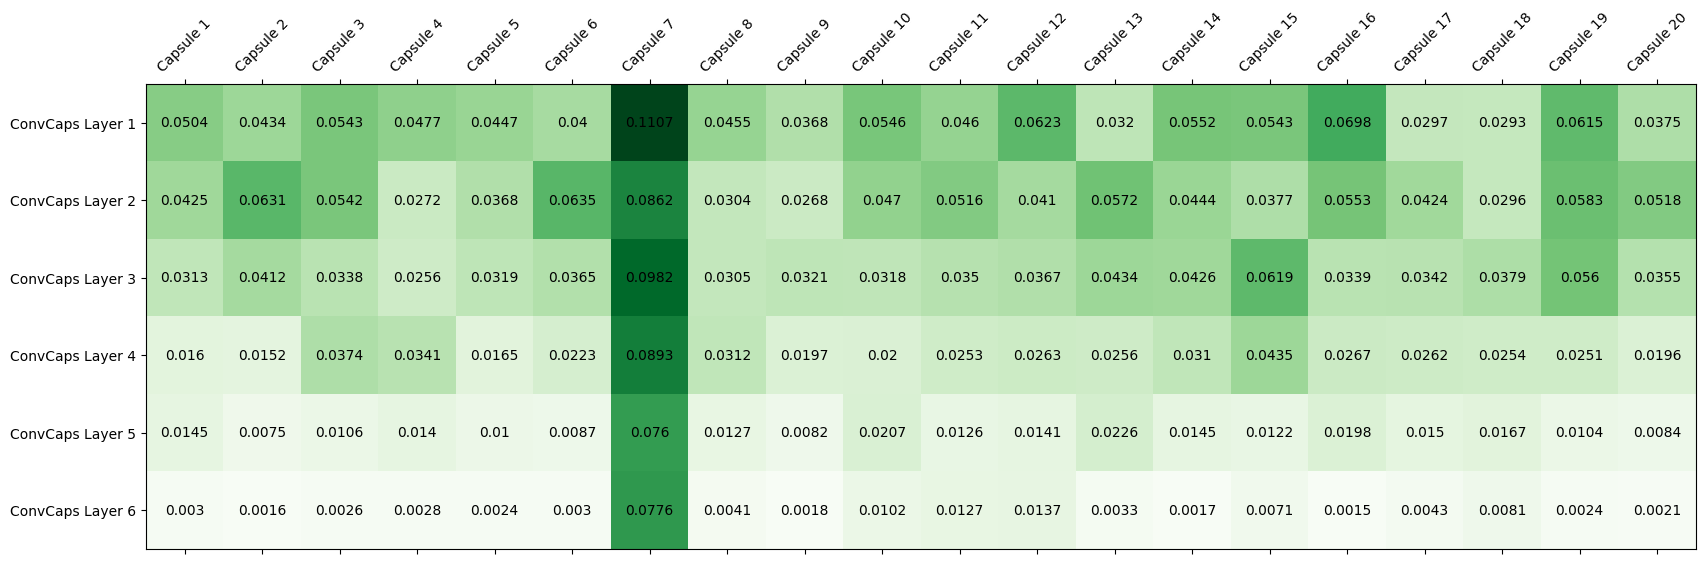

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter6_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

ConvCaps Activation for Epoch 1

In [ ]:
trained_inter6_capsnet_model_epoch1 = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter6_capsnet_cifar10_model_Epoch1_of_15.pt')

multilayer_inter6_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config,
                                                               prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter6_capsnet_cifar10_model.load_state_dict(trained_inter6_capsnet_model_epoch1['model_state_dict'])

multilayer_inter6_capsnet_cifar10_model.name = 'trained_multilayer_inter6_capsnet_cifar10_model_epoch1'
multilayer_inter6_capsnet_cifar10_model = multilayer_inter6_capsnet_cifar10_model.to(device)
multilayer_inter6_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
epoch1_convcaps_activations = utils.extract_convcaps_activations(multilayer_inter6_capsnet_cifar10_model,
                                                                  test_loader, logger, CIFAR10_TRAIN_DIR, device)

03/03 03:31:36 AM | trained_multilayer_inter6_capsnet_cifar10_model_epoch1 - Iterations=1/313, Batch Size=32, Top 1 Acc=68.750, Top 5 Acc=96.875
INFO:capsnet:trained_multilayer_inter6_capsnet_cifar10_model_epoch1 - Iterations=1/313, Batch Size=32, Top 1 Acc=68.750, Top 5 Acc=96.875
03/03 03:31:36 AM | trained_multilayer_inter6_capsnet_cifar10_model_epoch1 - Iterations=2/313, Batch Size=32, Top 1 Acc=60.938, Top 5 Acc=90.625
INFO:capsnet:trained_multilayer_inter6_capsnet_cifar10_model_epoch1 - Iterations=2/313, Batch Size=32, Top 1 Acc=60.938, Top 5 Acc=90.625
03/03 03:31:36 AM | trained_multilayer_inter6_capsnet_cifar10_model_epoch1 - Iterations=3/313, Batch Size=32, Top 1 Acc=65.625, Top 5 Acc=92.708
INFO:capsnet:trained_multilayer_inter6_capsnet_cifar10_model_epoch1 - Iterations=3/313, Batch Size=32, Top 1 Acc=65.625, Top 5 Acc=92.708
03/03 03:31:37 AM | trained_multilayer_inter6_capsnet_cifar10_model_epoch1 - Iterations=4/313, Batch Size=32, Top 1 Acc=64.844, Top 5 Acc=93.750
INFO:c

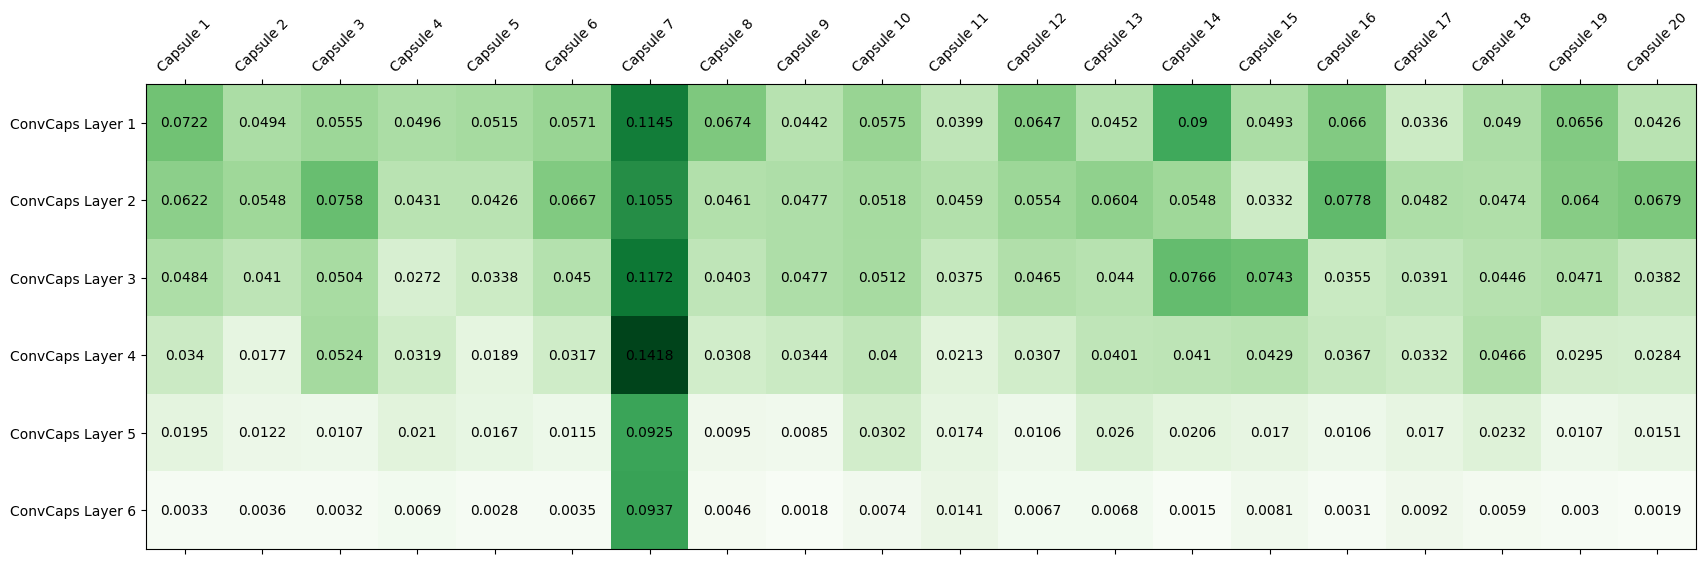

In [ ]:
utils.plot_caps_layers_activations(epoch1_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers)

ConvCaps Activation for Epoch 15

In [ ]:
trained_inter6_capsnet_model_epoch15 = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter6_capsnet_cifar10_model_Epoch15_of_15.pt')

multilayer_inter6_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                    model_conv_config=model_conv_config,
                                                                    prim_caps_channels=prim_caps_channels,
                                                                    prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter6_capsnet_cifar10_model.load_state_dict(trained_inter6_capsnet_model_epoch15['model_state_dict'])

multilayer_inter6_capsnet_cifar10_model.name = 'trained_multilayer_inter6_capsnet_cifar10_model_epoch15'
multilayer_inter6_capsnet_cifar10_model = multilayer_inter6_capsnet_cifar10_model.to(device)
multilayer_inter6_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
epoch15_convcaps_activations = utils.extract_convcaps_activations(multilayer_inter6_capsnet_cifar10_model,
                                                                  test_loader, logger, CIFAR10_TRAIN_DIR, device)

03/03 03:32:39 AM | trained_multilayer_inter6_capsnet_cifar10_model_epoch15 - Iterations=1/313, Batch Size=32, Top 1 Acc=81.250, Top 5 Acc=100.000
INFO:capsnet:trained_multilayer_inter6_capsnet_cifar10_model_epoch15 - Iterations=1/313, Batch Size=32, Top 1 Acc=81.250, Top 5 Acc=100.000
03/03 03:32:39 AM | trained_multilayer_inter6_capsnet_cifar10_model_epoch15 - Iterations=2/313, Batch Size=32, Top 1 Acc=70.312, Top 5 Acc=90.625
INFO:capsnet:trained_multilayer_inter6_capsnet_cifar10_model_epoch15 - Iterations=2/313, Batch Size=32, Top 1 Acc=70.312, Top 5 Acc=90.625
03/03 03:32:39 AM | trained_multilayer_inter6_capsnet_cifar10_model_epoch15 - Iterations=3/313, Batch Size=32, Top 1 Acc=76.042, Top 5 Acc=90.625
INFO:capsnet:trained_multilayer_inter6_capsnet_cifar10_model_epoch15 - Iterations=3/313, Batch Size=32, Top 1 Acc=76.042, Top 5 Acc=90.625
03/03 03:32:39 AM | trained_multilayer_inter6_capsnet_cifar10_model_epoch15 - Iterations=4/313, Batch Size=32, Top 1 Acc=78.125, Top 5 Acc=92.1

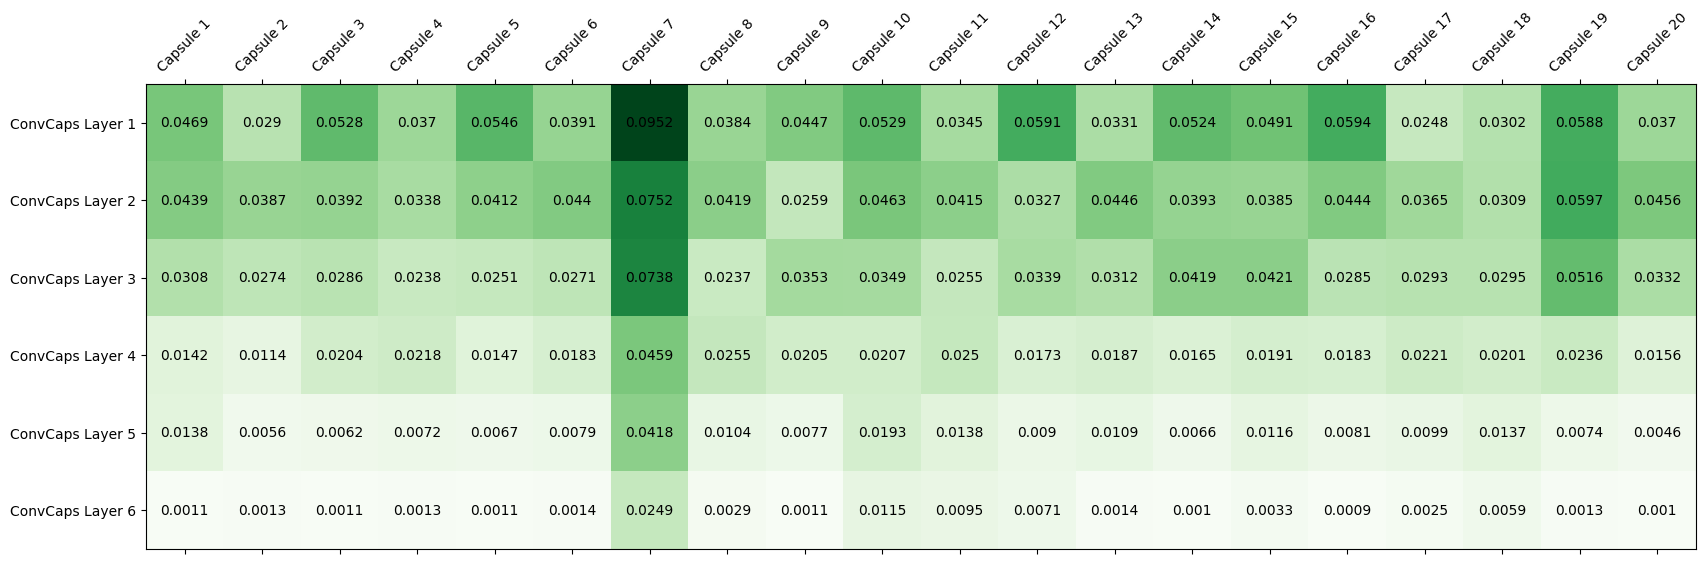

In [ ]:
utils.plot_caps_layers_activations(epoch15_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

In [ ]:
n_epochs = 15

for epoch in range(2, n_epochs):
    trained_inter6_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter6_capsnet_cifar10_model_Epoch{}_of_15.pt'.format(epoch))

    multilayer_inter6_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                model_conv_config=model_conv_config,
                                                                prim_caps_channels=prim_caps_channels,
                                                                prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

    multilayer_inter6_capsnet_cifar10_model.load_state_dict(trained_inter6_capsnet_model['model_state_dict'])

    multilayer_inter6_capsnet_cifar10_model.name = 'trained_multilayer_inter6_capsnet_cifar10_model_epoch{}'.format(epoch)
    multilayer_inter6_capsnet_cifar10_model = multilayer_inter6_capsnet_cifar10_model.to(device)

    utils.extract_convcaps_activations(multilayer_inter6_capsnet_cifar10_model, test_loader, logger, CIFAR10_TRAIN_DIR, device)

Streaming output truncated to the last 5000 lines.
03/03 04:13:59 AM | trained_multilayer_inter6_capsnet_cifar10_model_epoch7 - Iterations=13/313, Batch Size=32, Top 1 Acc=74.038, Top 5 Acc=97.837
INFO:capsnet:trained_multilayer_inter6_capsnet_cifar10_model_epoch7 - Iterations=13/313, Batch Size=32, Top 1 Acc=74.038, Top 5 Acc=97.837
03/03 04:13:59 AM | trained_multilayer_inter6_capsnet_cifar10_model_epoch7 - Iterations=14/313, Batch Size=32, Top 1 Acc=73.661, Top 5 Acc=97.768
INFO:capsnet:trained_multilayer_inter6_capsnet_cifar10_model_epoch7 - Iterations=14/313, Batch Size=32, Top 1 Acc=73.661, Top 5 Acc=97.768
03/03 04:13:59 AM | trained_multilayer_inter6_capsnet_cifar10_model_epoch7 - Iterations=15/313, Batch Size=32, Top 1 Acc=73.125, Top 5 Acc=97.500
INFO:capsnet:trained_multilayer_inter6_capsnet_cifar10_model_epoch7 - Iterations=15/313, Batch Size=32, Top 1 Acc=73.125, Top 5 Acc=97.500
03/03 04:13:59 AM | trained_multilayer_inter6_capsnet_cifar10_model_epoch7 - Iterations=16/313

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter6_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

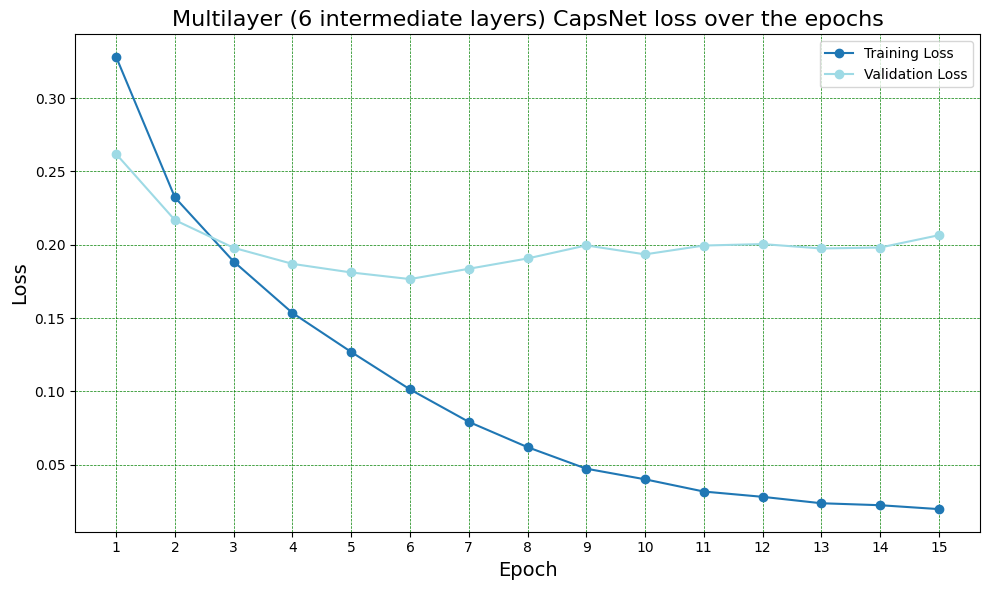

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (6 intermediate layers) CapsNet loss over the epochs')

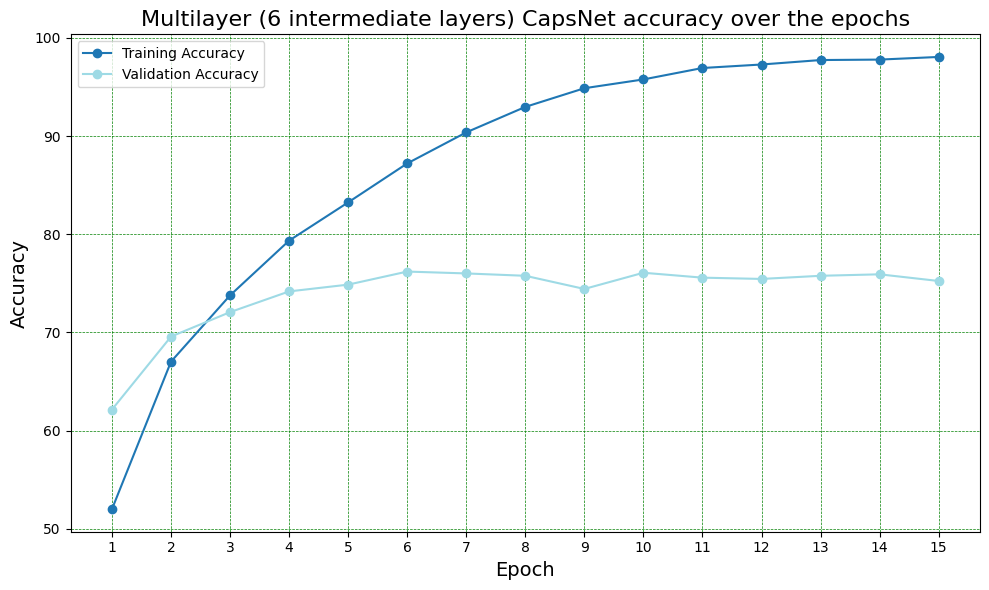

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (6 intermediate layers) CapsNet accuracy over the epochs')

## 7 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/20Caps8Dim/"
batch_size=32
n_epochs=15
n_class=10

n_caps_layers=7
prim_caps_channels=20
prim_caps_dim=8

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size':[3, 3, 3, 3],
                     'stride':[1, 2, 1, 2],
                     'padding':[1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

100%|██████████| 170498071/170498071 [00:03<00:00, 48131383.44it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
multilayer_inter7_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter7_capsnet_cifar10_model.name = 'multilayer_inter7_capsnet_cifar10_model'
multilayer_inter7_capsnet_cifar10_model = multilayer_inter7_capsnet_cifar10_model.to(device)
multilayer_inter7_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter7_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/11 07:01:31 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.8100, Top 1 Acc=9.38, Top 5 Acc=46.88
INFO:capsnet:multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.8100, Top 1 Acc=9.38, Top 5 Acc=46.88
02/11 07:01:43 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.8100, Top 1 Acc=9.94, Top 5 Acc=49.15
INFO:capsnet:multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.8100, Top 1 Acc=9.94, Top 5 Acc=49.15
02/11 07:01:55 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.8100, Top 1 Acc=10.05, Top 5 Acc=50.14
INFO:capsnet:multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.8100, Top 1 Acc=10.05, Top 5 Acc=50.14
02/11 07:02:08 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.8100, Top 1 Acc=10.34, Top 5 Acc=50.2

Checkpoint start

In [ ]:
%%time
n_epochs=15
checkpoint_file = CIFAR10_TRAIN_DIR+'Trained_multilayer_inter7_capsnet_cifar10_model_Epoch8_of_15.pt'

best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter7_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device,
                                                  checkpoint_file=checkpoint_file)

02/13 09:33:14 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=9, Iteration=(0/1563), Loss=0.8100, Top 1 Acc=12.50, Top 5 Acc=71.88
INFO:capsnet:multilayer_inter7_capsnet_cifar10_model Training - Epoch=9, Iteration=(0/1563), Loss=0.8100, Top 1 Acc=12.50, Top 5 Acc=71.88
02/13 09:33:28 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=9, Iteration=(32/1563), Loss=0.8100, Top 1 Acc=8.62, Top 5 Acc=49.15
INFO:capsnet:multilayer_inter7_capsnet_cifar10_model Training - Epoch=9, Iteration=(32/1563), Loss=0.8100, Top 1 Acc=8.62, Top 5 Acc=49.15
02/13 09:33:41 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=9, Iteration=(64/1563), Loss=0.8100, Top 1 Acc=9.18, Top 5 Acc=49.90
INFO:capsnet:multilayer_inter7_capsnet_cifar10_model Training - Epoch=9, Iteration=(64/1563), Loss=0.8100, Top 1 Acc=9.18, Top 5 Acc=49.90
02/13 09:33:55 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=9, Iteration=(96/1563), Loss=0.8100, Top 1 Acc=9.21, Top 5 Acc=50.26

CPU times: user 1h 16min 36s, sys: 4min 7s, total: 1h 20min 43s
Wall time: 1h 21min 29s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter7_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter7_capsnet_cifar10_model.pt')

best_multilayer_inter7_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter7_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter7_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter7_capsnet_cifar10_model.name = 'best_multilayer_inter7_capsnet_cifar10_model'
best_multilayer_inter7_capsnet_cifar10_model = best_multilayer_inter7_capsnet_cifar10_model.to(device)
best_multilayer_inter7_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
capsnet_inter7_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter7_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/17 12:51:06 AM | best_multilayer_inter7_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=34.375
INFO:capsnet:best_multilayer_inter7_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=34.375
02/17 12:51:06 AM | best_multilayer_inter7_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=4.688, Top 5 Acc=35.938
INFO:capsnet:best_multilayer_inter7_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=4.688, Top 5 Acc=35.938
02/17 12:51:06 AM | best_multilayer_inter7_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=40.625
INFO:capsnet:best_multilayer_inter7_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=40.625
02/17 12:51:06 AM | best_multilayer_inter7_capsnet_cifar10_model - Iterations=4/313, Batch Size=32, Top 1 Acc=7.812, Top 5 Acc=46.094
INFO:capsnet:best_multilayer_inter7_capsnet_cifar10_model - Iterations=4/313, Batch

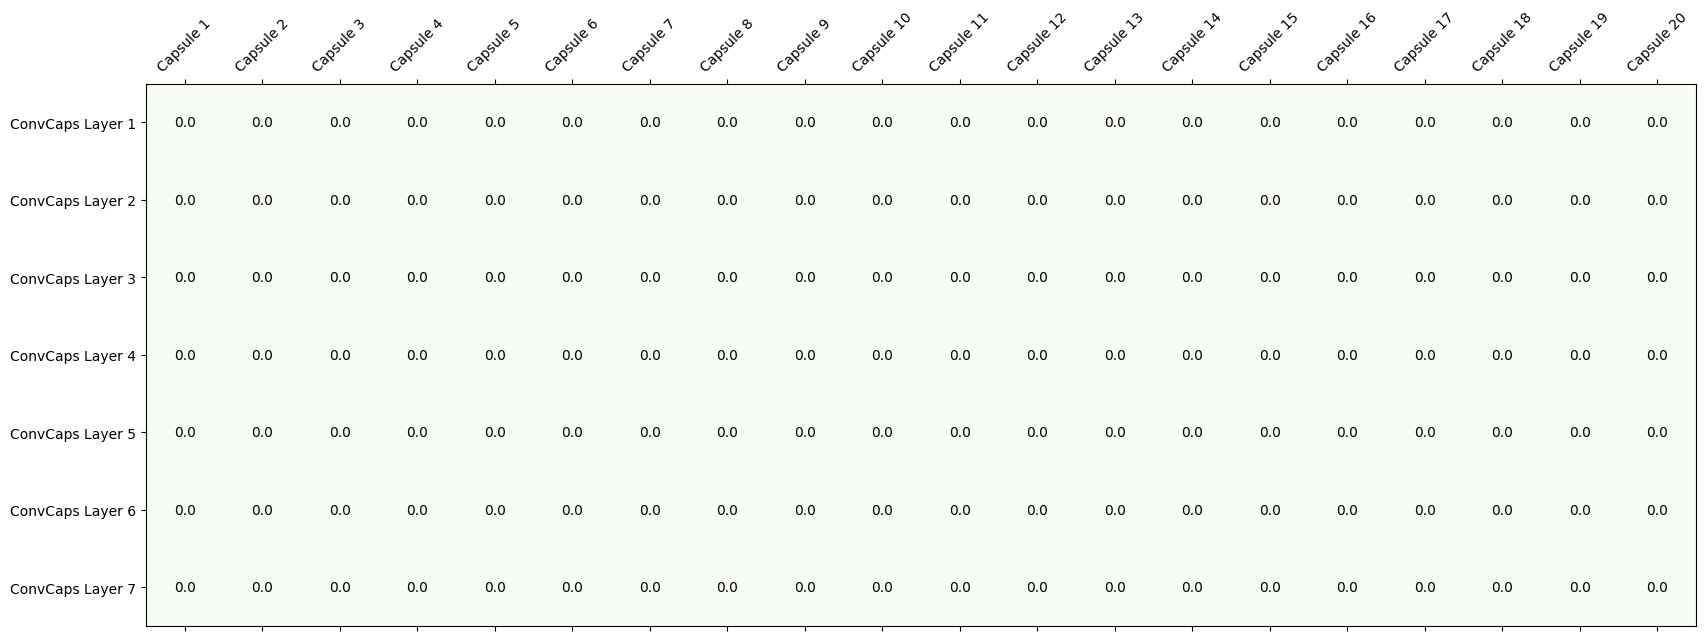

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter7_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

In [ ]:
n_epochs = 15

for epoch in range(1, n_epochs+1):
    trained_inter7_capsnet_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter7_capsnet_cifar10_model_Epoch{}_of_15.pt'.format(epoch))

    multilayer_inter7_capsnet_cifar10_model.load_state_dict(trained_inter7_capsnet_model['model_state_dict'])

    multilayer_inter7_capsnet_cifar10_model.name = 'trained_multilayer_inter7_capsnet_cifar10_model_epoch{}'.format(epoch)
    multilayer_inter7_capsnet_cifar10_model = multilayer_inter7_capsnet_cifar10_model.to(device)

    utils.extract_convcaps_activations(multilayer_inter7_capsnet_cifar10_model, test_loader, logger, CIFAR10_TRAIN_DIR, device)

Streaming output truncated to the last 5000 lines.
03/04 03:24:47 AM | trained_multilayer_inter7_capsnet_cifar10_model_epoch8 - Iterations=13/313, Batch Size=32, Top 1 Acc=8.413, Top 5 Acc=46.635
INFO:capsnet:trained_multilayer_inter7_capsnet_cifar10_model_epoch8 - Iterations=13/313, Batch Size=32, Top 1 Acc=8.413, Top 5 Acc=46.635
03/04 03:24:47 AM | trained_multilayer_inter7_capsnet_cifar10_model_epoch8 - Iterations=14/313, Batch Size=32, Top 1 Acc=8.259, Top 5 Acc=47.321
INFO:capsnet:trained_multilayer_inter7_capsnet_cifar10_model_epoch8 - Iterations=14/313, Batch Size=32, Top 1 Acc=8.259, Top 5 Acc=47.321
03/04 03:24:48 AM | trained_multilayer_inter7_capsnet_cifar10_model_epoch8 - Iterations=15/313, Batch Size=32, Top 1 Acc=7.917, Top 5 Acc=47.708
INFO:capsnet:trained_multilayer_inter7_capsnet_cifar10_model_epoch8 - Iterations=15/313, Batch Size=32, Top 1 Acc=7.917, Top 5 Acc=47.708
03/04 03:24:48 AM | trained_multilayer_inter7_capsnet_cifar10_model_epoch8 - Iterations=16/313, Batc

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter7_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

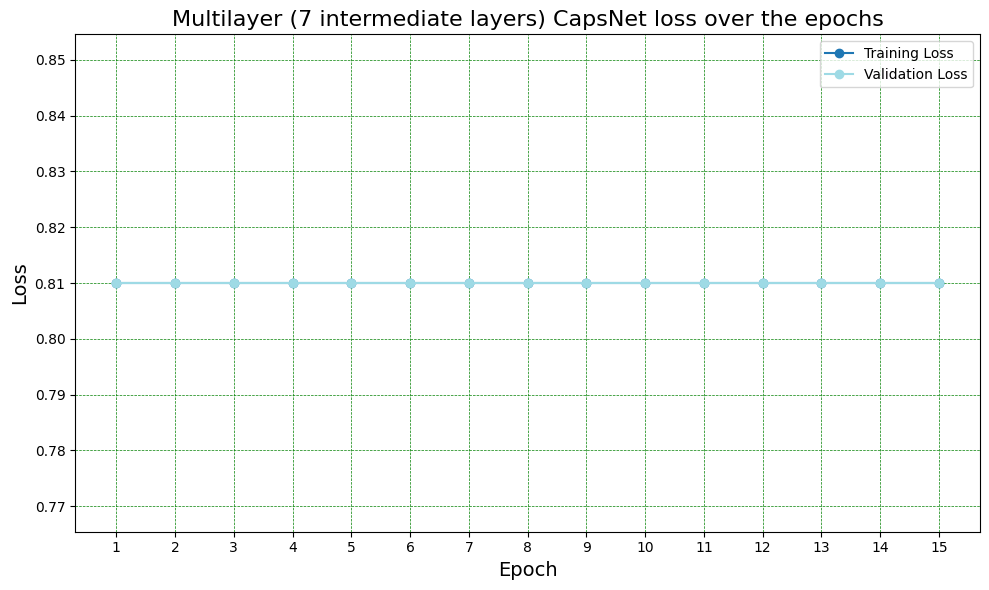

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (7 intermediate layers) CapsNet loss over the epochs')

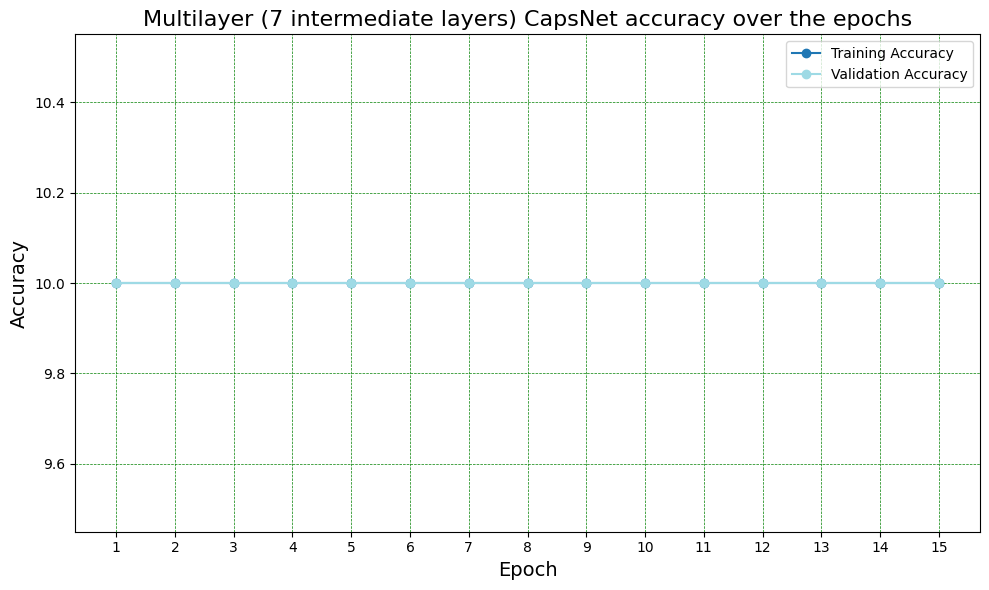

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (7 intermediate layers) CapsNet accuracy over the epochs')

## 8 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/20Caps8Dim/"
batch_size=32
n_epochs=15
n_class=10

n_caps_layers=8
prim_caps_channels=20
prim_caps_dim=8

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size':[3, 3, 3, 3],
                     'stride':[1, 2, 1, 2],
                     'padding':[1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter8_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter8_capsnet_cifar10_model.name = 'multilayer_inter8_capsnet_cifar10_model'
multilayer_inter8_capsnet_cifar10_model = multilayer_inter8_capsnet_cifar10_model.to(device)
multilayer_inter8_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter8_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/13 11:00:13 PM | multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.8100, Top 1 Acc=6.25, Top 5 Acc=59.38
INFO:capsnet:multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.8100, Top 1 Acc=6.25, Top 5 Acc=59.38
02/13 11:00:26 PM | multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.8100, Top 1 Acc=8.62, Top 5 Acc=48.11
INFO:capsnet:multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.8100, Top 1 Acc=8.62, Top 5 Acc=48.11
02/13 11:00:40 PM | multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.8100, Top 1 Acc=9.81, Top 5 Acc=47.69
INFO:capsnet:multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.8100, Top 1 Acc=9.81, Top 5 Acc=47.69
02/13 11:00:53 PM | multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.8100, Top 1 Acc=9.47, Top 5 Acc=47.91
I

CPU times: user 2h 39min 29s, sys: 9min 4s, total: 2h 48min 33s
Wall time: 2h 48min 8s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter8_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter8_capsnet_cifar10_model.pt')

best_multilayer_inter8_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter8_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter8_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter8_capsnet_cifar10_model.name = 'best_multilayer_inter8_capsnet_cifar10_model'
best_multilayer_inter8_capsnet_cifar10_model = best_multilayer_inter8_capsnet_cifar10_model.to(device)
best_multilayer_inter8_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
capsnet_inter8_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter8_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/17 12:48:56 AM | best_multilayer_inter8_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=34.375
INFO:capsnet:best_multilayer_inter8_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=34.375
02/17 12:48:56 AM | best_multilayer_inter8_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=4.688, Top 5 Acc=35.938
INFO:capsnet:best_multilayer_inter8_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=4.688, Top 5 Acc=35.938
02/17 12:48:56 AM | best_multilayer_inter8_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=40.625
INFO:capsnet:best_multilayer_inter8_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=40.625
02/17 12:48:56 AM | best_multilayer_inter8_capsnet_cifar10_model - Iterations=4/313, Batch Size=32, Top 1 Acc=7.812, Top 5 Acc=46.094
INFO:capsnet:best_multilayer_inter8_capsnet_cifar10_model - Iterations=4/313, Batch

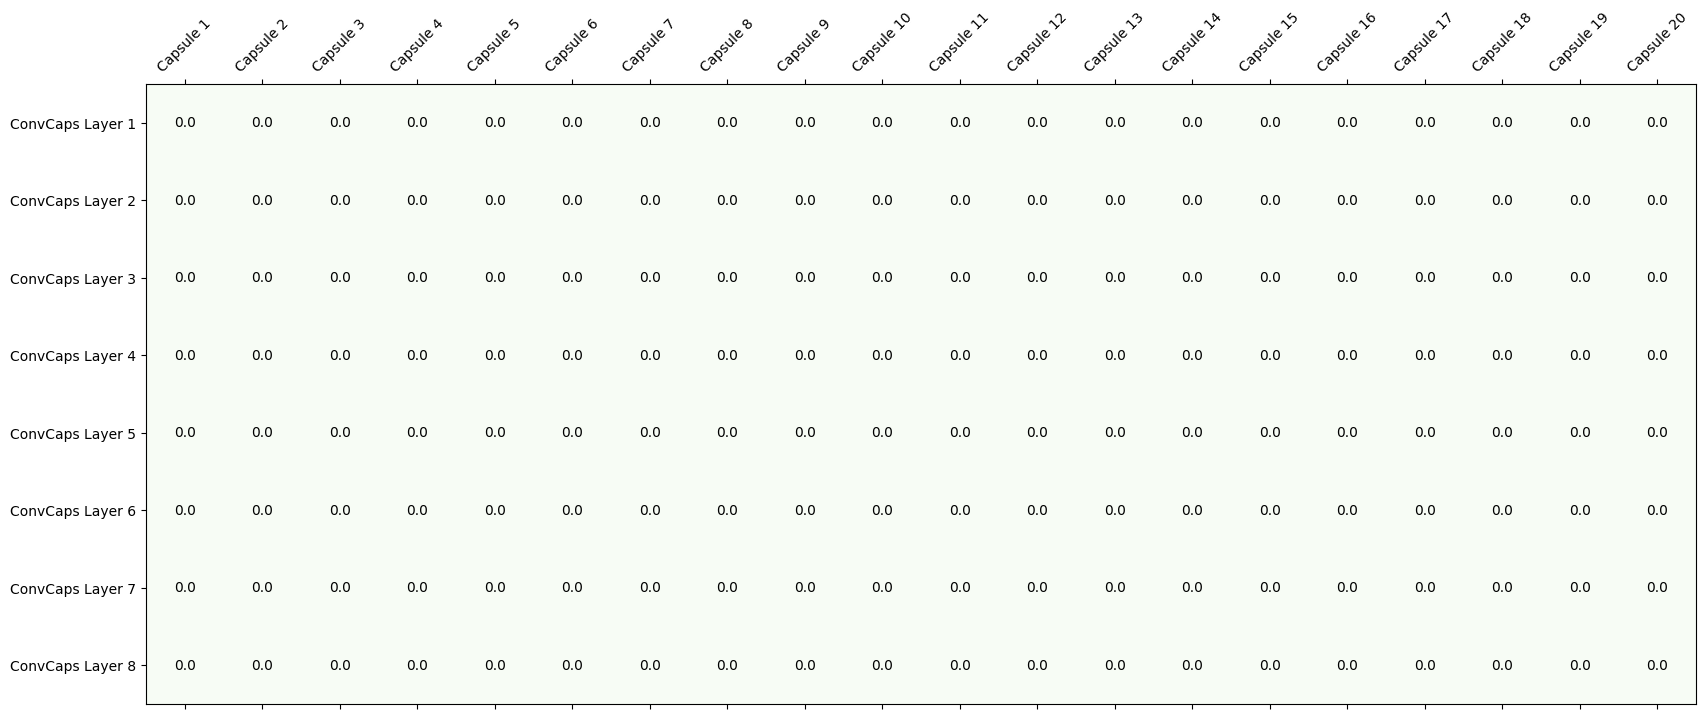

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter8_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter8_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

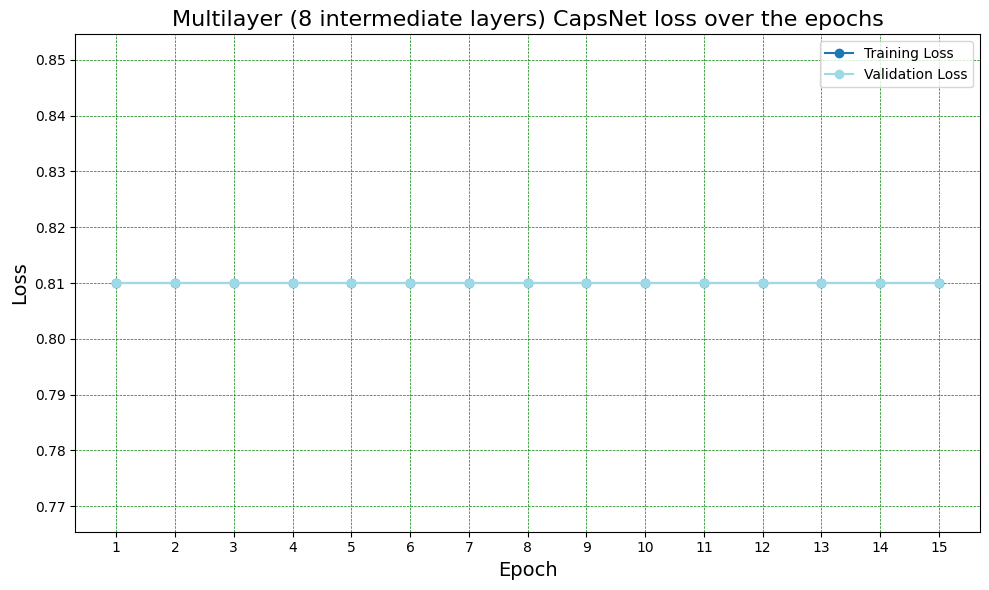

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (8 intermediate layers) CapsNet loss over the epochs')

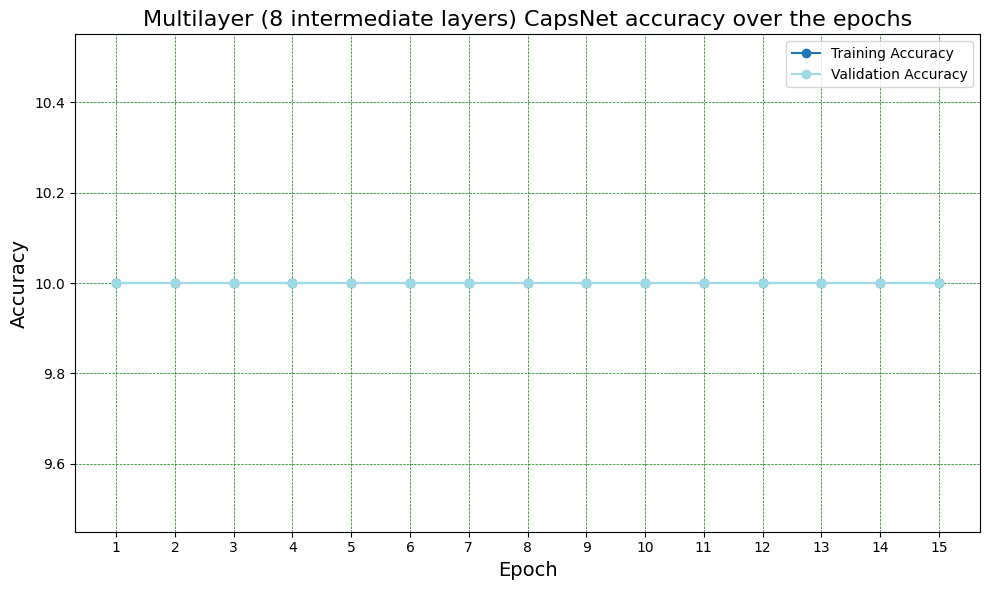

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (8 intermediate layers) CapsNet accuracy over the epochs')

## 9 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/20Caps8Dim/"
batch_size=32
n_epochs=15
n_class=10

n_caps_layers=9
prim_caps_channels=20
prim_caps_dim=8

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size':[3, 3, 3, 3],
                     'stride':[1, 2, 1, 2],
                     'padding':[1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter9_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter9_capsnet_cifar10_model.name = 'multilayer_inter9_capsnet_cifar10_model'
multilayer_inter9_capsnet_cifar10_model = multilayer_inter9_capsnet_cifar10_model.to(device)
multilayer_inter9_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter9_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/14 01:48:22 AM | multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.8100, Top 1 Acc=15.62, Top 5 Acc=56.25
INFO:capsnet:multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.8100, Top 1 Acc=15.62, Top 5 Acc=56.25
02/14 01:48:37 AM | multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.8100, Top 1 Acc=9.56, Top 5 Acc=48.58
INFO:capsnet:multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.8100, Top 1 Acc=9.56, Top 5 Acc=48.58
02/14 01:48:52 AM | multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.8100, Top 1 Acc=10.67, Top 5 Acc=50.96
INFO:capsnet:multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.8100, Top 1 Acc=10.67, Top 5 Acc=50.96
02/14 01:49:08 AM | multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.8100, Top 1 Acc=10.34, Top 5 Acc=49

CPU times: user 3h 1min 23s, sys: 10min 2s, total: 3h 11min 25s
Wall time: 3h 10min 57s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter9_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter9_capsnet_cifar10_model.pt')

best_multilayer_inter9_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter9_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter9_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter9_capsnet_cifar10_model.name = 'best_multilayer_inter9_capsnet_cifar10_model'
best_multilayer_inter9_capsnet_cifar10_model = best_multilayer_inter9_capsnet_cifar10_model.to(device)
best_multilayer_inter9_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
capsnet_inter9_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter9_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/17 12:46:22 AM | best_multilayer_inter9_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=34.375
INFO:capsnet:best_multilayer_inter9_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=34.375
02/17 12:46:23 AM | best_multilayer_inter9_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=4.688, Top 5 Acc=35.938
INFO:capsnet:best_multilayer_inter9_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=4.688, Top 5 Acc=35.938
02/17 12:46:23 AM | best_multilayer_inter9_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=40.625
INFO:capsnet:best_multilayer_inter9_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=40.625
02/17 12:46:23 AM | best_multilayer_inter9_capsnet_cifar10_model - Iterations=4/313, Batch Size=32, Top 1 Acc=7.812, Top 5 Acc=46.094
INFO:capsnet:best_multilayer_inter9_capsnet_cifar10_model - Iterations=4/313, Batch

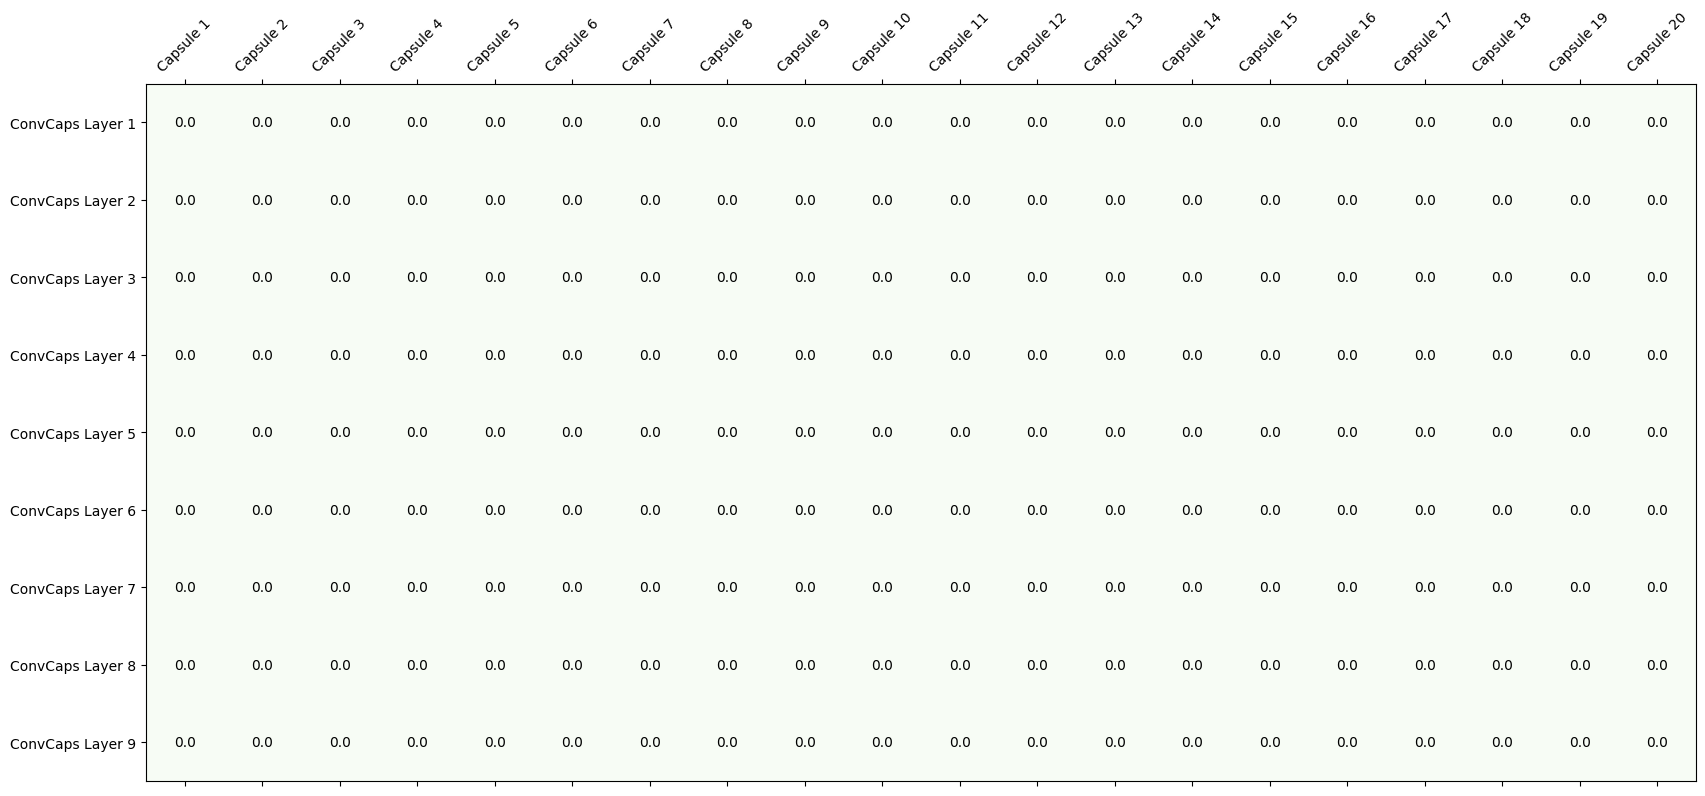

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter9_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter9_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

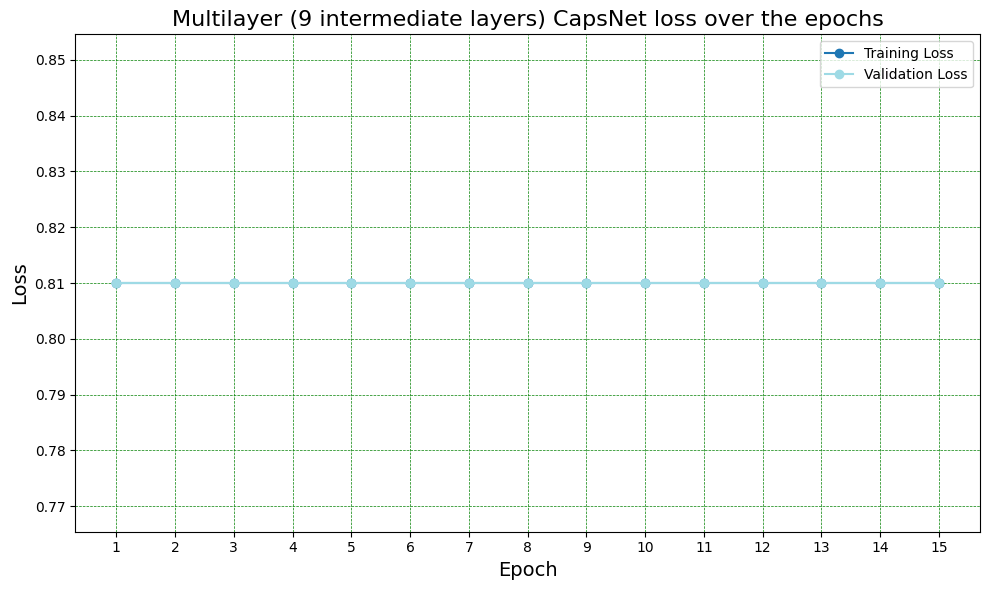

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (9 intermediate layers) CapsNet loss over the epochs')

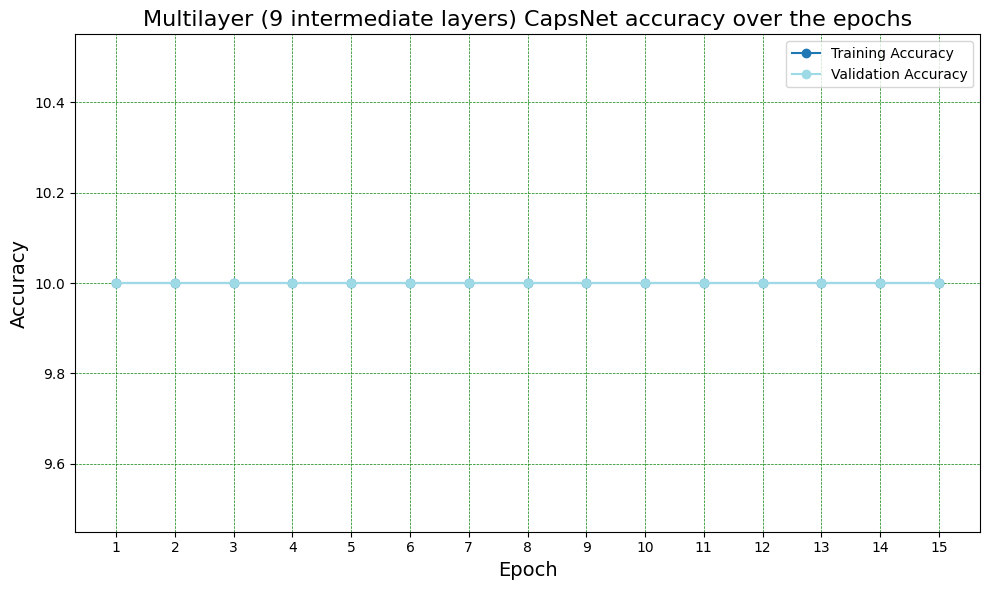

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (9 intermediate layers) CapsNet accuracy over the epochs')

## 10 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/20Caps8Dim/"
batch_size=32
n_epochs=15
n_class=10

n_caps_layers=10
prim_caps_channels=20
prim_caps_dim=8

model_conv_config = {'in_img_h':32,
                     'in_img_w':32,
                     'in_img_c':3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

100%|██████████| 170498071/170498071 [00:12<00:00, 13150999.81it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
multilayer_inter10_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter10_capsnet_cifar10_model.name = 'multilayer_inter10_capsnet_cifar10_model'
multilayer_inter10_capsnet_cifar10_model = multilayer_inter10_capsnet_cifar10_model.to(device)
multilayer_inter10_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter10_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/14 04:59:22 AM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.8100, Top 1 Acc=6.25, Top 5 Acc=40.62
INFO:capsnet:multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/1563), Loss=0.8100, Top 1 Acc=6.25, Top 5 Acc=40.62
02/14 04:59:39 AM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.8100, Top 1 Acc=10.80, Top 5 Acc=52.37
INFO:capsnet:multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(32/1563), Loss=0.8100, Top 1 Acc=10.80, Top 5 Acc=52.37
02/14 04:59:55 AM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.8100, Top 1 Acc=10.00, Top 5 Acc=50.62
INFO:capsnet:multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/1563), Loss=0.8100, Top 1 Acc=10.00, Top 5 Acc=50.62
02/14 05:00:12 AM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(96/1563), Loss=0.8100, Top 1 Acc=9.83, Top 5 

CPU times: user 3h 19min 54s, sys: 10min 54s, total: 3h 30min 48s
Wall time: 3h 30min 28s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter10_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter10_capsnet_cifar10_model.pt')

best_multilayer_inter10_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                    model_conv_config=model_conv_config,
                                                                    prim_caps_channels=prim_caps_channels,
                                                                    prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter10_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter10_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter10_capsnet_cifar10_model.name = 'best_multilayer_inter10_capsnet_cifar10_model'
best_multilayer_inter10_capsnet_cifar10_model = best_multilayer_inter10_capsnet_cifar10_model.to(device)
best_multilayer_inter10_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
capsnet_inter10_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter10_capsnet_cifar10_model,
                                                                          test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/17 12:40:48 AM | best_multilayer_inter10_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=34.375
INFO:capsnet:best_multilayer_inter10_capsnet_cifar10_model - Iterations=1/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=34.375
02/17 12:40:48 AM | best_multilayer_inter10_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=4.688, Top 5 Acc=35.938
INFO:capsnet:best_multilayer_inter10_capsnet_cifar10_model - Iterations=2/313, Batch Size=32, Top 1 Acc=4.688, Top 5 Acc=35.938
02/17 12:40:48 AM | best_multilayer_inter10_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=40.625
INFO:capsnet:best_multilayer_inter10_capsnet_cifar10_model - Iterations=3/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=40.625
02/17 12:40:48 AM | best_multilayer_inter10_capsnet_cifar10_model - Iterations=4/313, Batch Size=32, Top 1 Acc=7.812, Top 5 Acc=46.094
INFO:capsnet:best_multilayer_inter10_capsnet_cifar10_model - Iterations=4/31

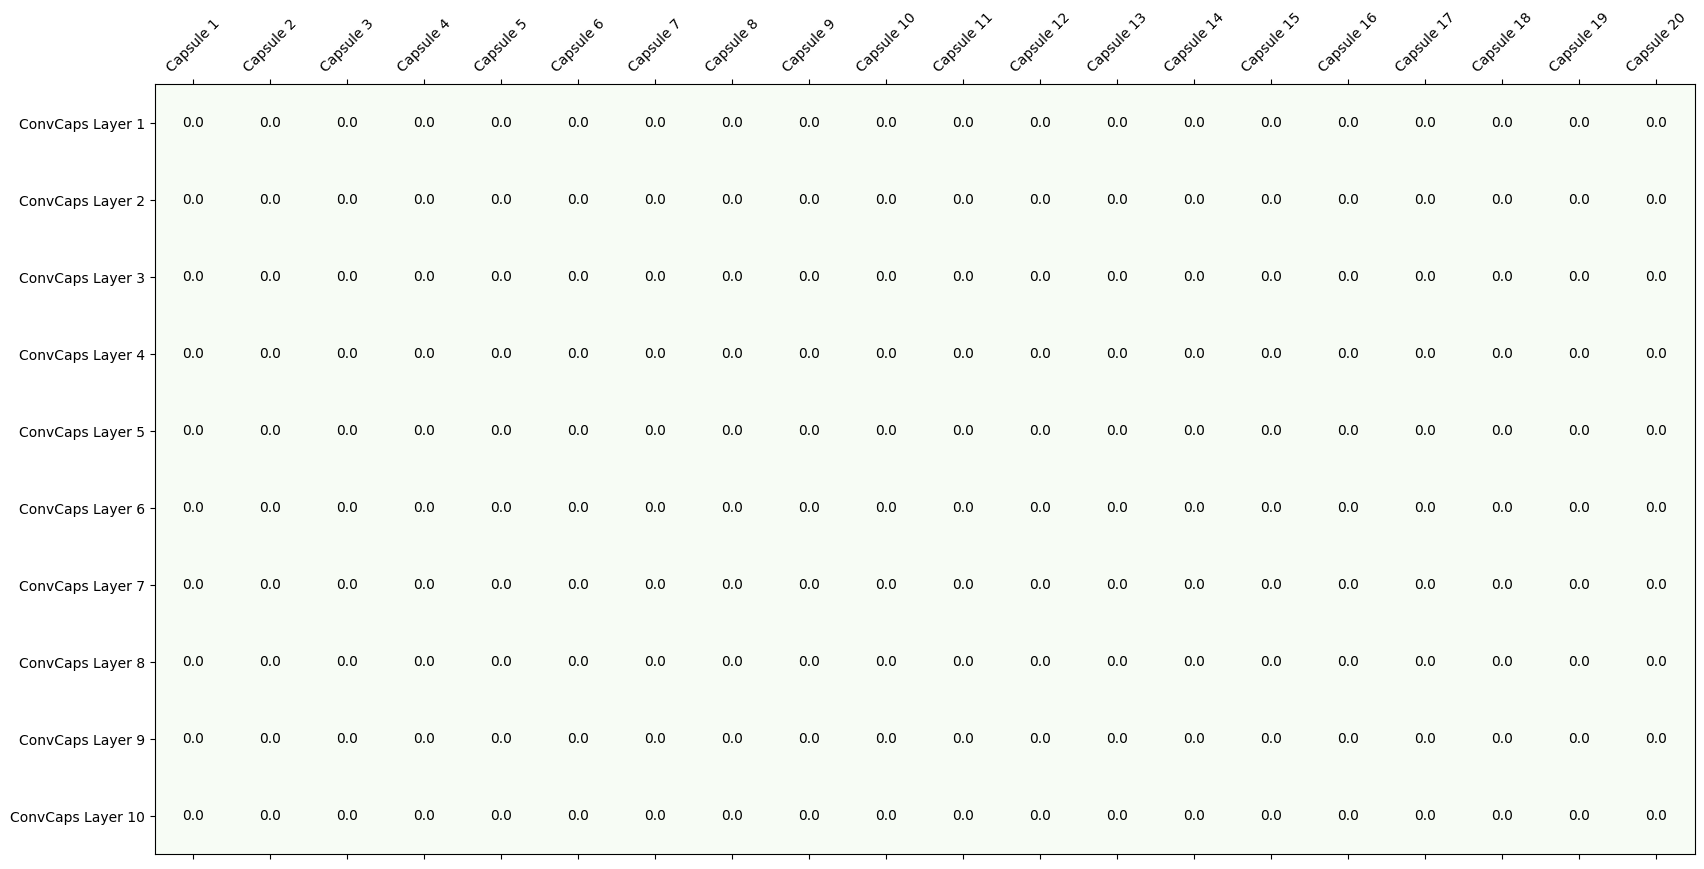

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter10_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

ConvCaps Activation for Epoch 1

In [ ]:
trained_inter10_capsnet_model_epoch1 = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter10_capsnet_cifar10_model_Epoch1_of_15.pt')

multilayer_inter10_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config,
                                                               prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter10_capsnet_cifar10_model.load_state_dict(trained_inter10_capsnet_model_epoch1['model_state_dict'])

multilayer_inter10_capsnet_cifar10_model.name = 'trained_multilayer_inter10_capsnet_cifar10_model_epoch1'
multilayer_inter10_capsnet_cifar10_model = multilayer_inter10_capsnet_cifar10_model.to(device)
multilayer_inter10_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
epoch1_convcaps_activations = utils.extract_convcaps_activations(multilayer_inter10_capsnet_cifar10_model,
                                                                  test_loader, logger, CIFAR10_TRAIN_DIR, device)

03/02 07:07:25 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=1/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=34.375
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=1/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=34.375
03/02 07:07:25 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=2/313, Batch Size=32, Top 1 Acc=4.688, Top 5 Acc=35.938
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=2/313, Batch Size=32, Top 1 Acc=4.688, Top 5 Acc=35.938
03/02 07:07:25 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=3/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=40.625
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=3/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=40.625
03/02 07:07:26 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=4/313, Batch Size=32, Top 1 Acc=7.812, Top 5 Acc=46.094
INFO:c

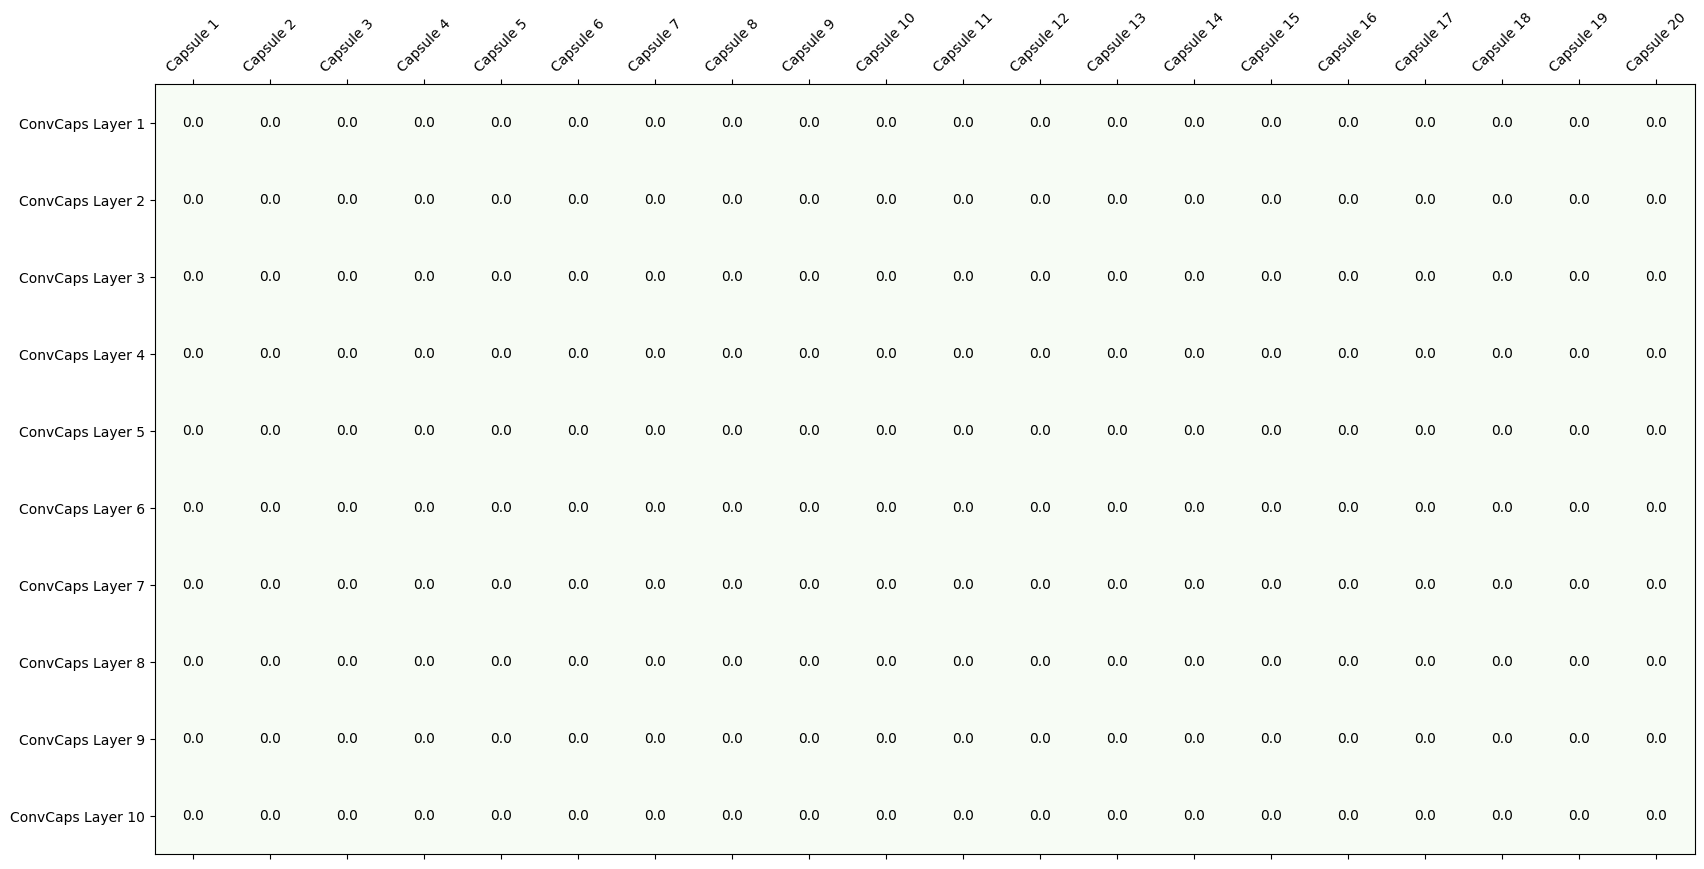

In [ ]:
utils.plot_caps_layers_activations(epoch1_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

ConvCaps Activation for Epoch 15

In [ ]:
trained_inter10_capsnet_model_epoch15 = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter10_capsnet_cifar10_model_Epoch15_of_15.pt')

multilayer_inter10_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                    model_conv_config=model_conv_config,
                                                                    prim_caps_channels=prim_caps_channels,
                                                                    prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter10_capsnet_cifar10_model.load_state_dict(trained_inter10_capsnet_model_epoch15['model_state_dict'])

multilayer_inter10_capsnet_cifar10_model.name = 'trained_multilayer_inter10_capsnet_cifar10_model_epoch15'
multilayer_inter10_capsnet_cifar10_model = multilayer_inter10_capsnet_cifar10_model.to(device)
multilayer_inter10_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(80, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(160, 160, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_co

In [ ]:
epoch15_convcaps_activations = utils.extract_convcaps_activations(multilayer_inter10_capsnet_cifar10_model,
                                                                  test_loader, logger, CIFAR10_TRAIN_DIR, device)

03/02 07:05:00 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=1/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=34.375
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=1/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=34.375
03/02 07:05:00 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=2/313, Batch Size=32, Top 1 Acc=4.688, Top 5 Acc=35.938
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=2/313, Batch Size=32, Top 1 Acc=4.688, Top 5 Acc=35.938
03/02 07:05:00 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=3/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=40.625
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=3/313, Batch Size=32, Top 1 Acc=6.250, Top 5 Acc=40.625
03/02 07:05:00 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=4/313, Batch Size=32, Top 1 Acc=7.812, Top 5 Acc=46.094

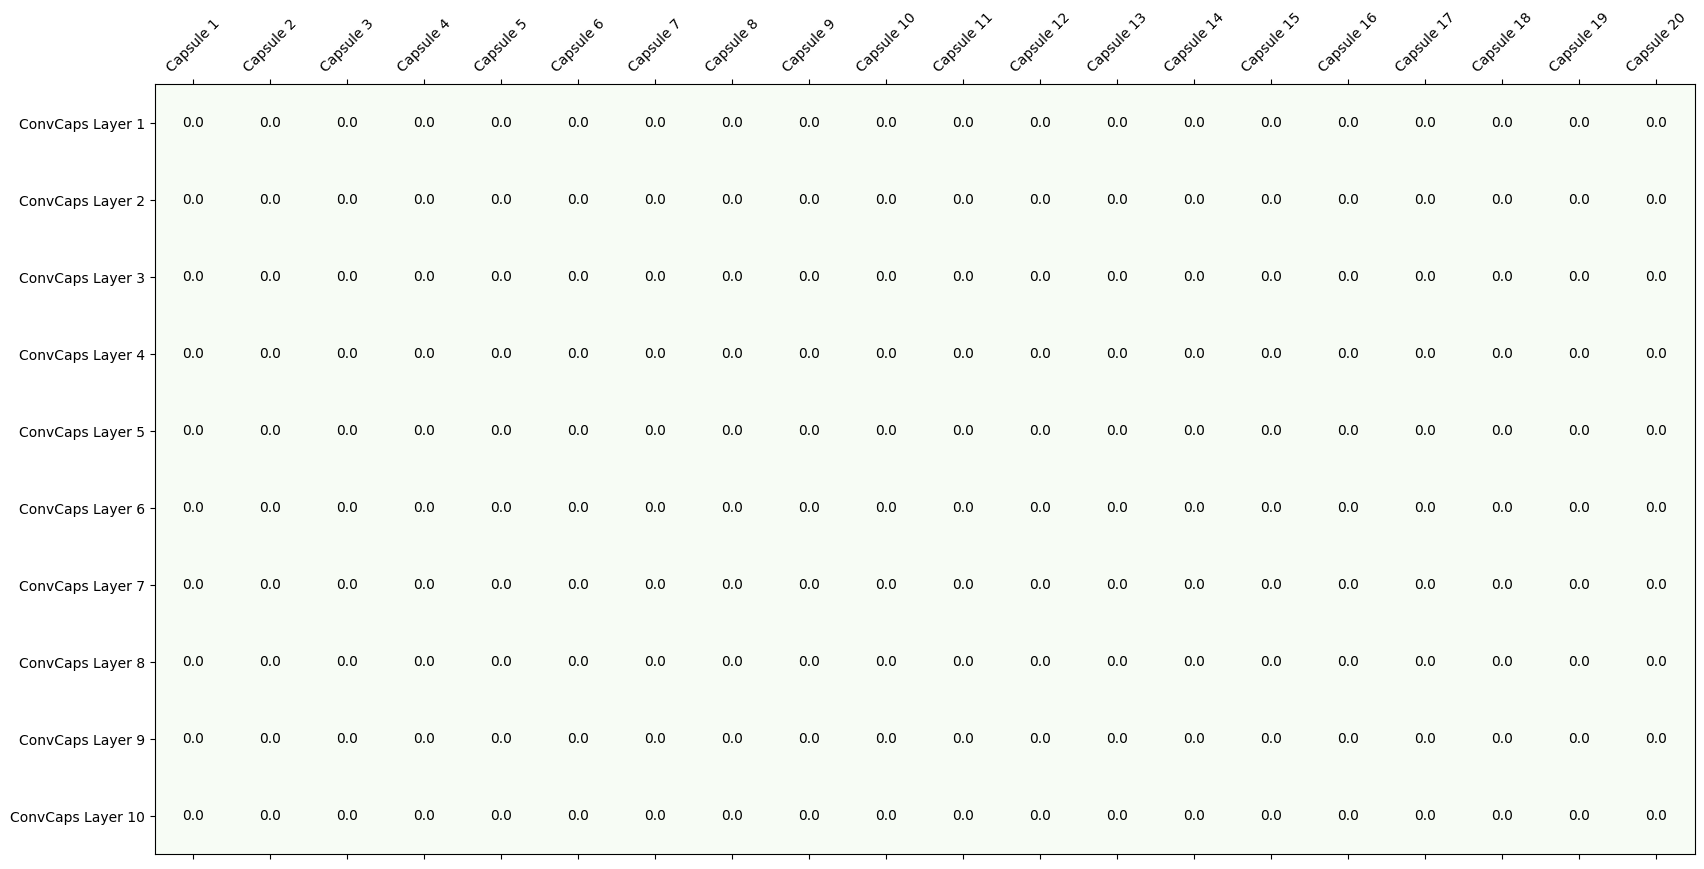

In [ ]:
utils.plot_caps_layers_activations(epoch15_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

In [ ]:
# from google.colab import runtime
# runtime.unassign()

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter10_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

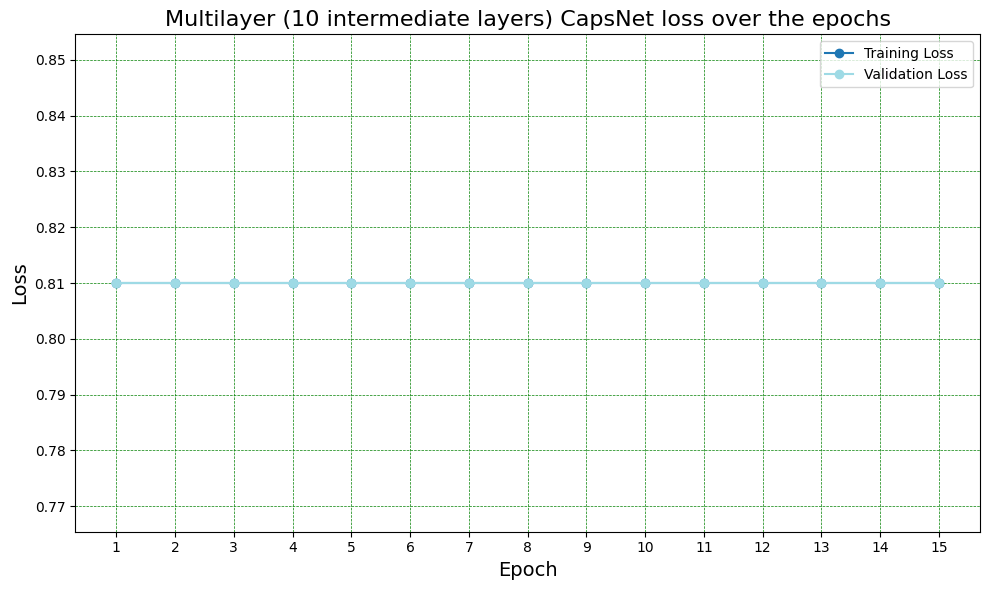

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (10 intermediate layers) CapsNet loss over the epochs')

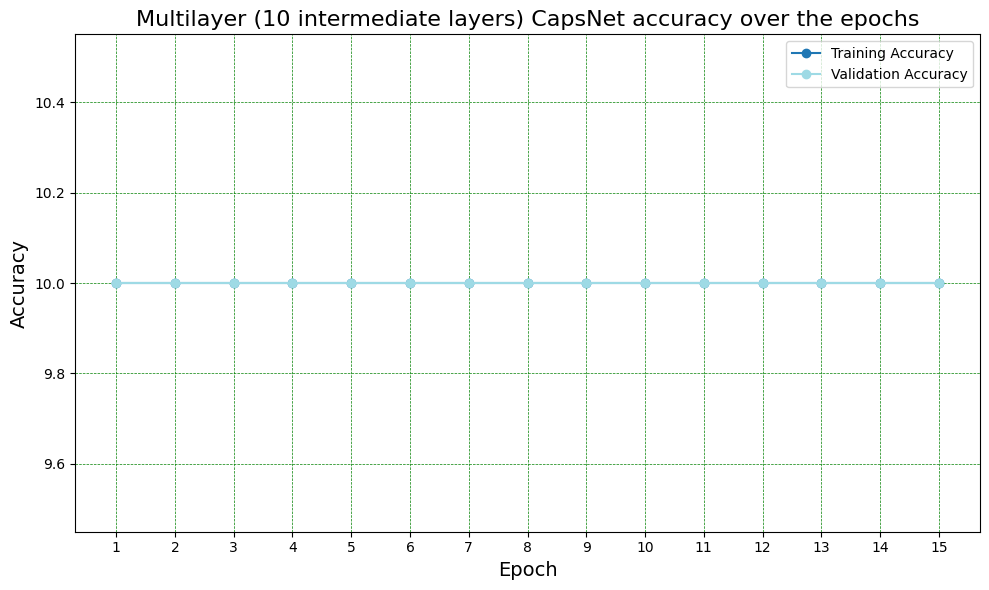

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (10 intermediate layers) CapsNet accuracy over the epochs')

## Plots for Base and All Multilayer CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/20Caps8Dim/"

base_capsnet_cifar10_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_base_capsnet_cifar10_model_Epoch30_of_30.pt')
multilayer_capsnet_inter1_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter1_capsnet_cifar10_model_Epoch30_of_30.pt')
multilayer_capsnet_inter2_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter2_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter3_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter3_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter4_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter4_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter5_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter5_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter6_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter6_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter7_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter7_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter8_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter8_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter9_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter9_capsnet_cifar10_model_Epoch15_of_15.pt')
multilayer_capsnet_inter10_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter10_capsnet_cifar10_model_Epoch15_of_15.pt')

In [ ]:
models = [base_capsnet_cifar10_model_data,
          multilayer_capsnet_inter1_model_data,
          multilayer_capsnet_inter2_model_data,
          multilayer_capsnet_inter3_model_data,
          multilayer_capsnet_inter4_model_data,
          multilayer_capsnet_inter5_model_data,
          multilayer_capsnet_inter6_model_data,
          multilayer_capsnet_inter7_model_data,
          multilayer_capsnet_inter8_model_data,
          multilayer_capsnet_inter9_model_data,
          multilayer_capsnet_inter10_model_data]

legends = ['Base',
           '1 InterLayer',
           '2 InterLayers',
           '3 InterLayers',
           '4 InterLayers',
           '5 InterLayers',
           '6 InterLayers',
           '7 InterLayers',
           '8 InterLayers',
           '9 InterLayers',
           '10 InterLayers']

n_epochs = 15

epoch_losses = np.zeros((len(models), n_epochs))
epoch_accuracies = np.zeros((len(models), n_epochs))

for indx, model in enumerate(models):
    epoch_losses[indx] = model['epoch_loss'][:,:15][1]
    epoch_accuracies[indx] = model['epoch_accuracy'][:, :15][1]

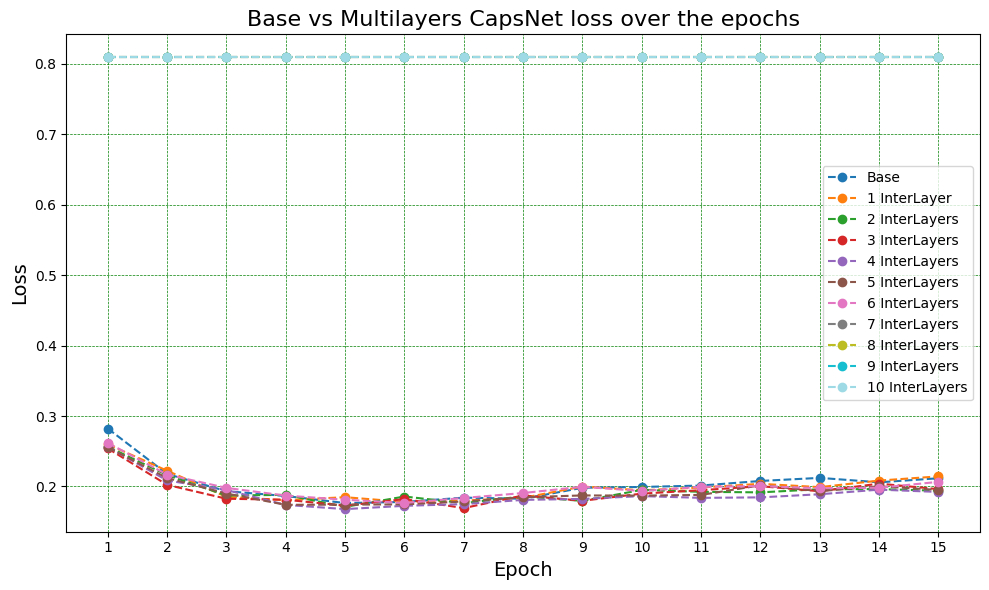

In [ ]:
utils.plot_line_chart(epoch_losses, legends, 'Epoch', 'Loss',
                      'Base vs Multilayers CapsNet loss over the epochs', marker='o', line='--')

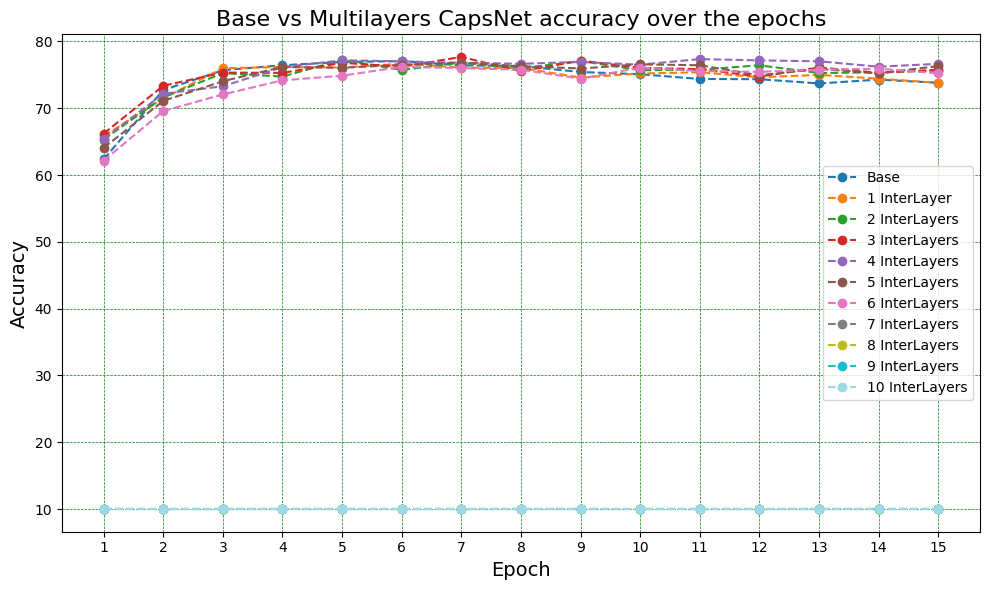

In [ ]:
utils.plot_line_chart(epoch_accuracies, legends, 'Epoch', 'Accuracy',
                      'Base vs Multilayers CapsNet accuracy over the epochs', marker='o', line='--')

## Flops and Params Count

In [ ]:
def count_caps_ops(m, x, y: torch.Tensor):
    x = x[0]
    x = x.view(x.size(0), x.size(1), 1, x.size(2), 1)

    count_mat = vision.calc_func.counter_matmul(m.weights.shape, x.shape)
    m.total_ops += count_mat

In [ ]:
input_cifar10_image_size = torch.randn(1, 3, 32, 32).to(device)

custom_ops = {caps.CapsLayer : count_caps_ops}

In [ ]:
base_capsnet_cifar10_model.eval()

flops, params = profile(base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,), verbose=False, custom_ops=custom_ops)
flops, params = clever_format([flops, params], format="%.3f")

print("{} CIFAR10 Flops = {}".format(base_capsnet_cifar10_model.name, flops))
print("{} CIFAR10 Params = {}".format(base_capsnet_cifar10_model.name, params))

base_capsnet_cifar10_model CIFAR10 Flops = 18.997M
base_capsnet_cifar10_model CIFAR10 Params = 888.504K


In [ ]:
prune_threshold = 0.125
pruned_12pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_12pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,), verbose=False, custom_ops=custom_ops)
flops, params = clever_format([flops, params], format="%.3f")

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_12pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_12pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

pruned_12pc_base_capsnet_cifar10_model CIFAR10 12.5% pruned Flops = 12.237M
pruned_12pc_base_capsnet_cifar10_model CIFAR10 12.5% pruned Params = 753.840K


In [ ]:
prune_threshold = 0.25
pruned_25pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_25pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,), verbose=False, custom_ops=custom_ops)
flops, params = clever_format([flops, params], format="%.3f")

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_25pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_25pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

pruned_25pc_base_capsnet_cifar10_model CIFAR10 25.0% pruned Flops = 10.309M
pruned_25pc_base_capsnet_cifar10_model CIFAR10 25.0% pruned Params = 638.988K


In [ ]:
prune_threshold = 0.375
pruned_37pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_37pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,), verbose=False, custom_ops=custom_ops)
flops, params = clever_format([flops, params], format="%.3f")

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_37pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_37pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

pruned_37pc_base_capsnet_cifar10_model CIFAR10 37.5% pruned Flops = 8.509M
pruned_37pc_base_capsnet_cifar10_model CIFAR10 37.5% pruned Params = 526.728K


In [ ]:
prune_threshold = 0.50
pruned_50pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_50pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,), verbose=False, custom_ops=custom_ops)
flops, params = clever_format([flops, params], format="%.3f")

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_50pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_50pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

pruned_50pc_base_capsnet_cifar10_model CIFAR10 50.0% pruned Flops = 5.165M
pruned_50pc_base_capsnet_cifar10_model CIFAR10 50.0% pruned Params = 410.556K


In [ ]:
prune_threshold = 0.625
pruned_62pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_62pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,), verbose=False, custom_ops=custom_ops)
flops, params = clever_format([flops, params], format="%.3f")

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_62pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_62pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

pruned_62pc_base_capsnet_cifar10_model CIFAR10 62.5% pruned Flops = 3.950M
pruned_62pc_base_capsnet_cifar10_model CIFAR10 62.5% pruned Params = 304.776K


In [ ]:
prune_threshold = 0.75
pruned_75pc_base_capsnet_cifar10_model.eval()

flops, params = profile(pruned_75pc_base_capsnet_cifar10_model, inputs=(input_cifar10_image_size,), verbose=False, custom_ops=custom_ops)
flops, params = clever_format([flops, params], format="%.3f")

print("{} CIFAR10 {}% pruned Flops = {}".format(pruned_75pc_base_capsnet_cifar10_model.name, prune_threshold*100, flops))
print("{} CIFAR10 {}% pruned Params = {}".format(pruned_75pc_base_capsnet_cifar10_model.name, prune_threshold*100, params))

pruned_75pc_base_capsnet_cifar10_model CIFAR10 75.0% pruned Flops = 1.855M
pruned_75pc_base_capsnet_cifar10_model CIFAR10 75.0% pruned Params = 197.676K
